<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9B%D0%A01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа 1**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Рыбаков Владислав Андреевич**

##**1. Скопируем проект по ссылке в локальную среду выполнения Google Colab https://github.com/ewatson2/EEL6812_DeepFool_Project**

In [ ]:
! git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (27/27), done.


##**2. Cменим директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта:**

In [ ]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


##**3. Выполним импорт нужных для работы библиотек:**

In [ ]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

## **4. Выполним импорт вспомогательных библиотек из локальных файлов проекта:**

In [ ]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

##**5. Установим случайное рандомное значение в виде переменной `rand_seed`={"Порядковый номер ученика группы"}, а также установим указанное значение для `np.random.seed` и `torch.manual_seed`:**

In [ ]:
rand_seed = 27
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## **6. Установим в качестве устройства видеокарту (Среды выполнения --> Сменить среду выполнения --> T4 GPU):**



In [ ]:
import torch
device = torch.device("cuda")
if device.type == 'cuda':
  torch.cuda.empty_cache()

##**7. Загрузим датасет MNIST c параметрами `mnist_mean = 0.5`, `mnist_std = 0.5`, `mnist_dim = 28`:**


In [ ]:
# Среднее значение для нормализации изображений из набора данных MNIST
mnist_mean = 0.5
# Стандартное отклонение для нормализации изображений
mnist_std = 0.5
# Размер изображений MNIST, который составляет 28 пикселей (28x28)
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.1kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



## **8. Загрузим датасет CIFAR-10 c параметрами `cifar_mean = [0.491, 0.482, 0.447]`; `cifar_std = [0.202,0.199, 0.201]`; `cifar_dim = 32`:**

In [ ]:
# Средние значения для нормализации изображений из набора данных CIFAR-10 по каждому из трех цветовых каналов (RGB)
cifar_mean = [0.491, 0.482, 0.447]
# Стандартные отклонения для нормализации изображений по каждому из цветовых каналов
cifar_std = [0.202, 0.199, 0.201]
# Размер изображений CIFAR-10, который составляет 32 пикселя (32x32)
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:16<00:00, 10.0MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


## **9. Выполним настройку и загрузку DataLoader с параметрами `batch_size = 64`; `workers = 4` и зададим гиперпараметры для DeepFool:**

In [ ]:
# Размер пакета (batch size), который указывает, сколько примеров будет загружаться за один раз
batch_size = 64
# Количество потоков (workers) для загрузки данных
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

# Устанавливаем размер пакета равный 10. Это означает, что за один раз будет обрабатываться 10 примеров данных
deep_batch_size = 10
# Задаем количество классов, которое равно 10
deep_num_classes = 10
# Параметр может использоваться для управления тем, насколько модель может "перепрыгнуть" через оптимальное значение во время обучения
deep_overshoot = 0.02
# Задаем максимальное количество итераций для процесса обучения, равное 50
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes, deep_overshoot, deep_max_iters]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## **10. Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам:**

In [ ]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results', device, model,
mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)
if device.type == 'cuda':
  torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


<ipython-input-10-eec3764c7697>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device(

## **11. После этого загрузим и оценим стойкость модели FCNet к FGSM и DeepFool атакам:**

In [ ]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cpu')))
evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)
if device.type == 'cuda':
  torch.cuda.empty_cache()

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


<ipython-input-11-68737621f03c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=torch.device('cp

## **12. Теперь выполним оценку атакующих примеров для сетей:**

<ipython-input-12-769d6467ee04>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.11

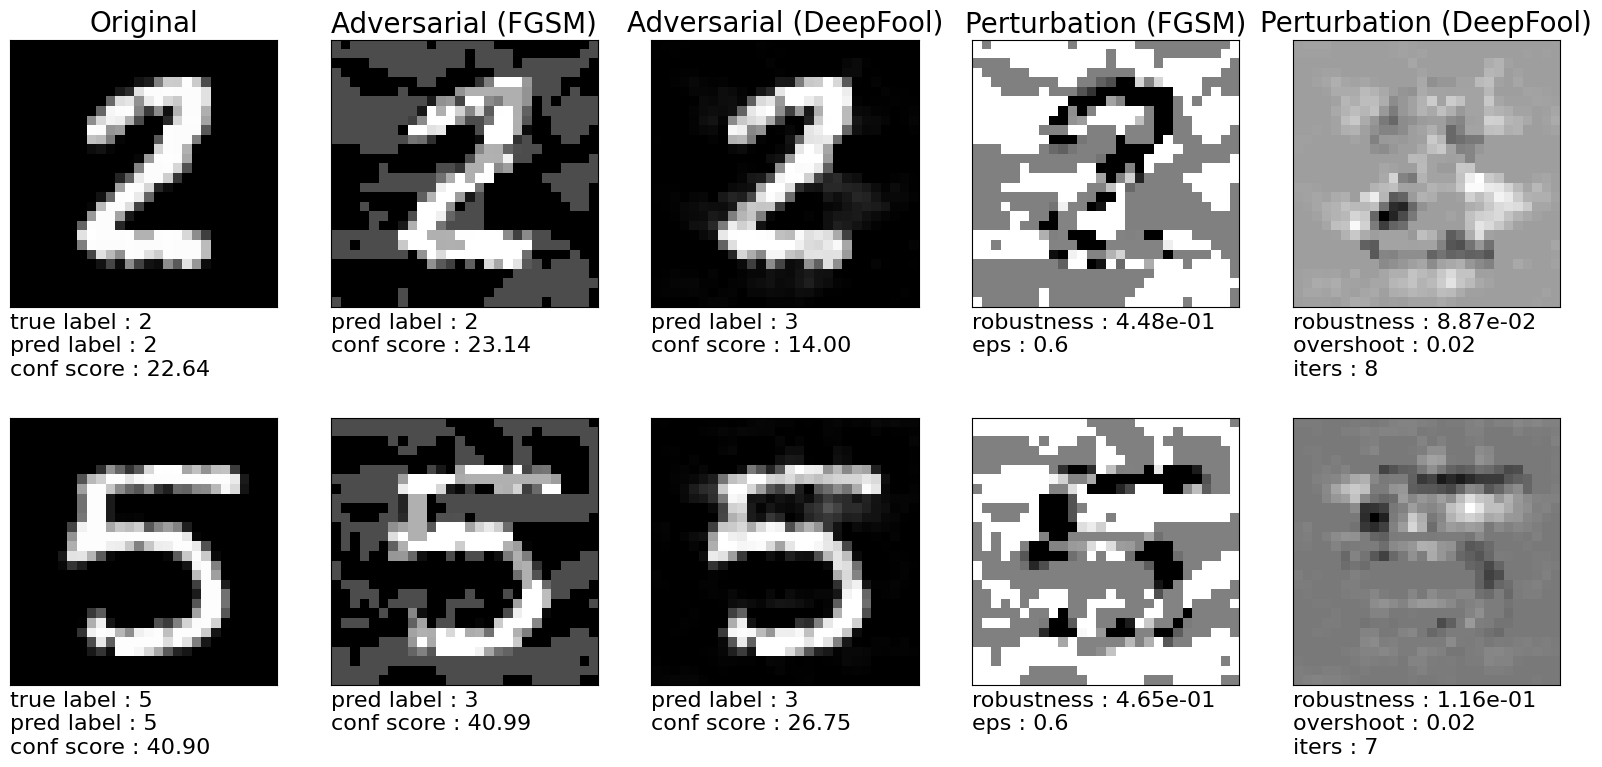

In [ ]:
# LeNet на датасете MNIST
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9)
if device.type == 'cuda':
  torch.cuda.empty_cache()

<ipython-input-13-b9a20e95d1c5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


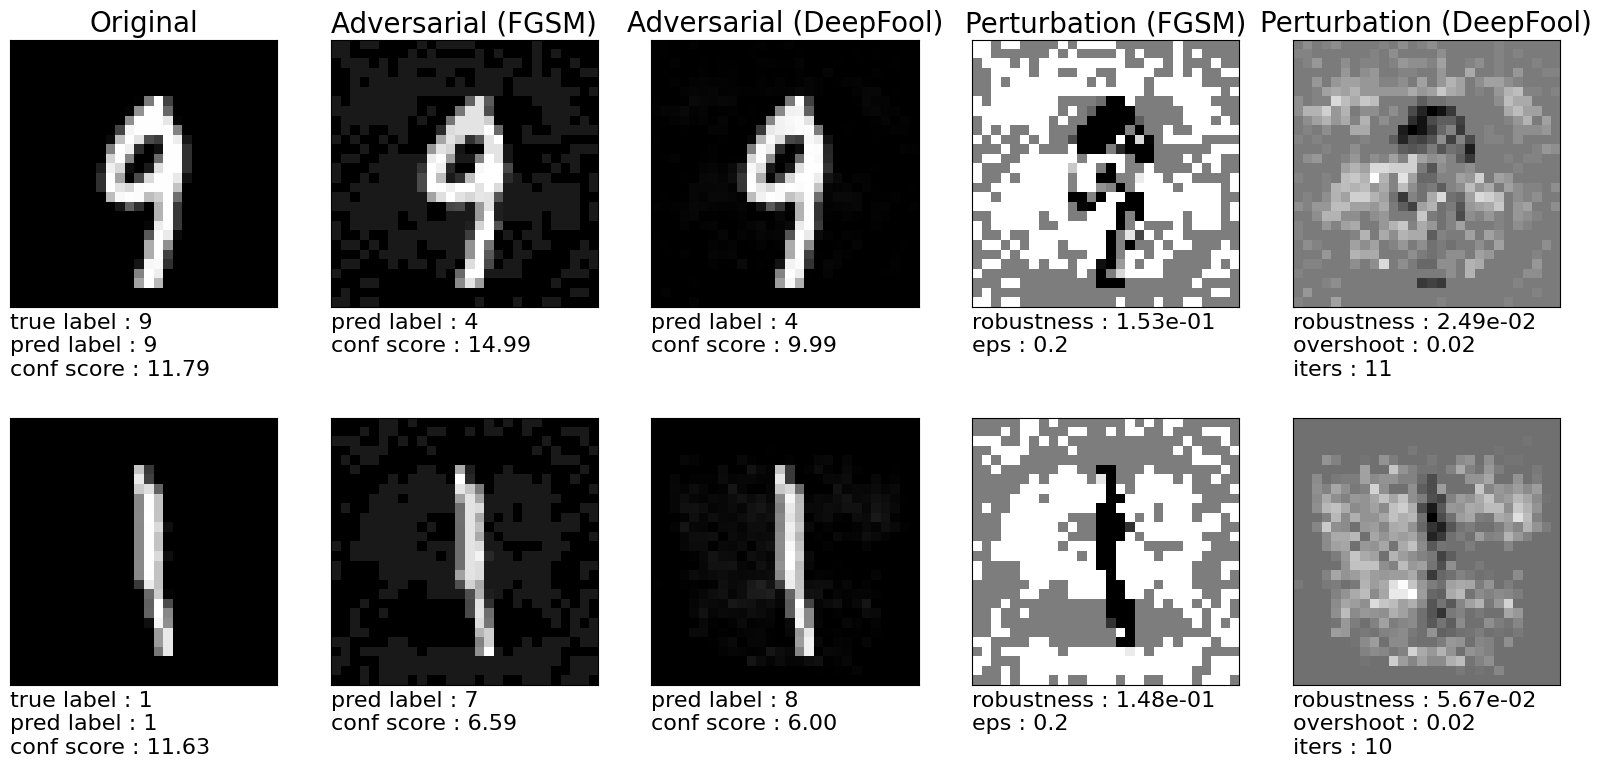

In [ ]:
# FCNet на датасете MNIST
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9)
if device.type == 'cuda':
  torch.cuda.empty_cache()

##**13. Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10:**

In [ ]:
# LeNet на датасете CIFAR
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda':
  torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-14-536097fda6a7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

## **14. Также выполним оценку атакующих примеров для сетей:**

<ipython-input-15-be896159bb6a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

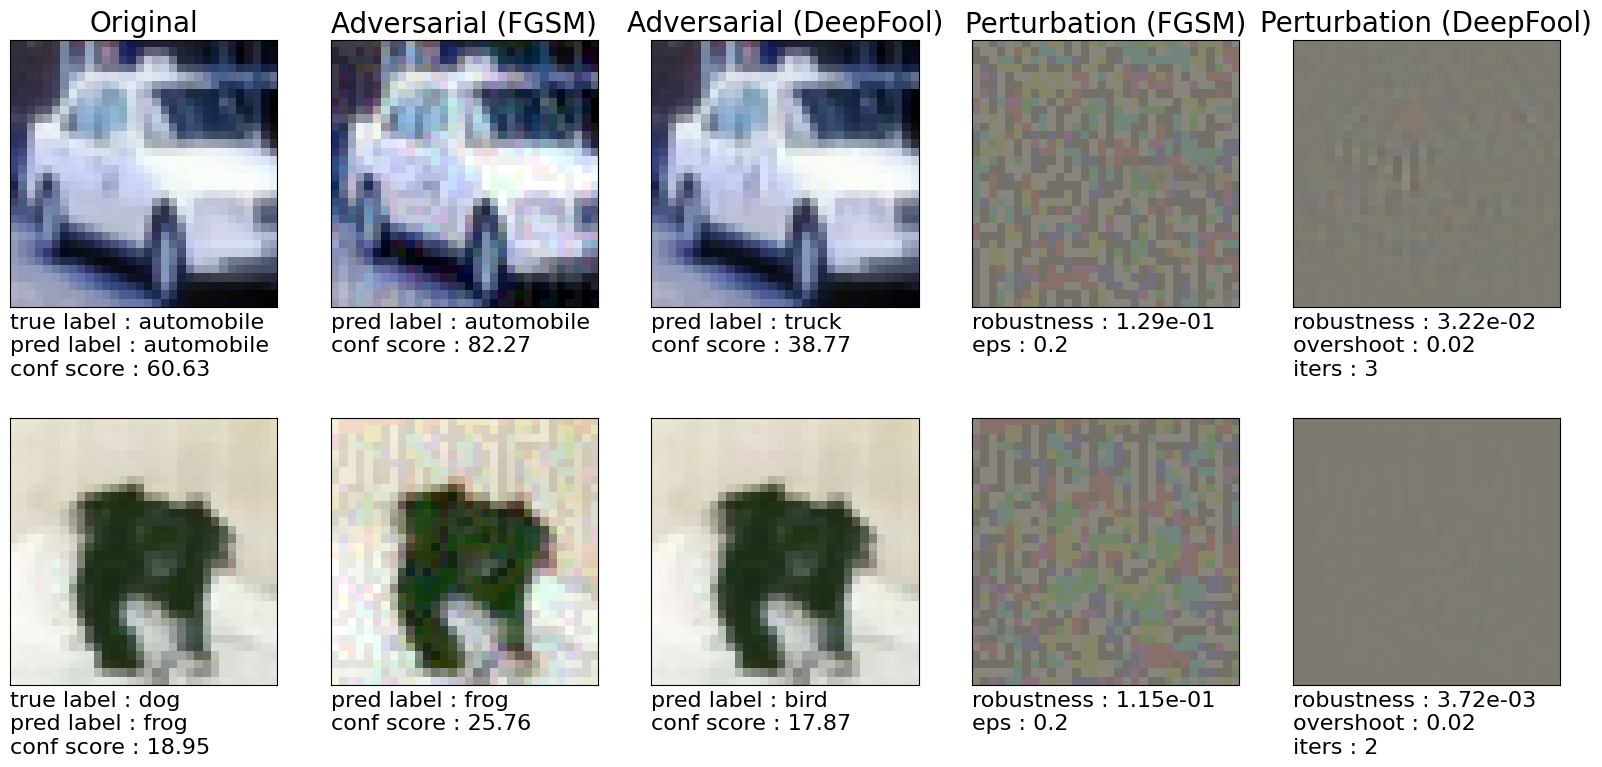

In [ ]:
# Network-in-Network на датасете CIFAR-10
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
if device.type == 'cuda':
  torch.cuda.empty_cache()

<ipython-input-16-67b6997ab449>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


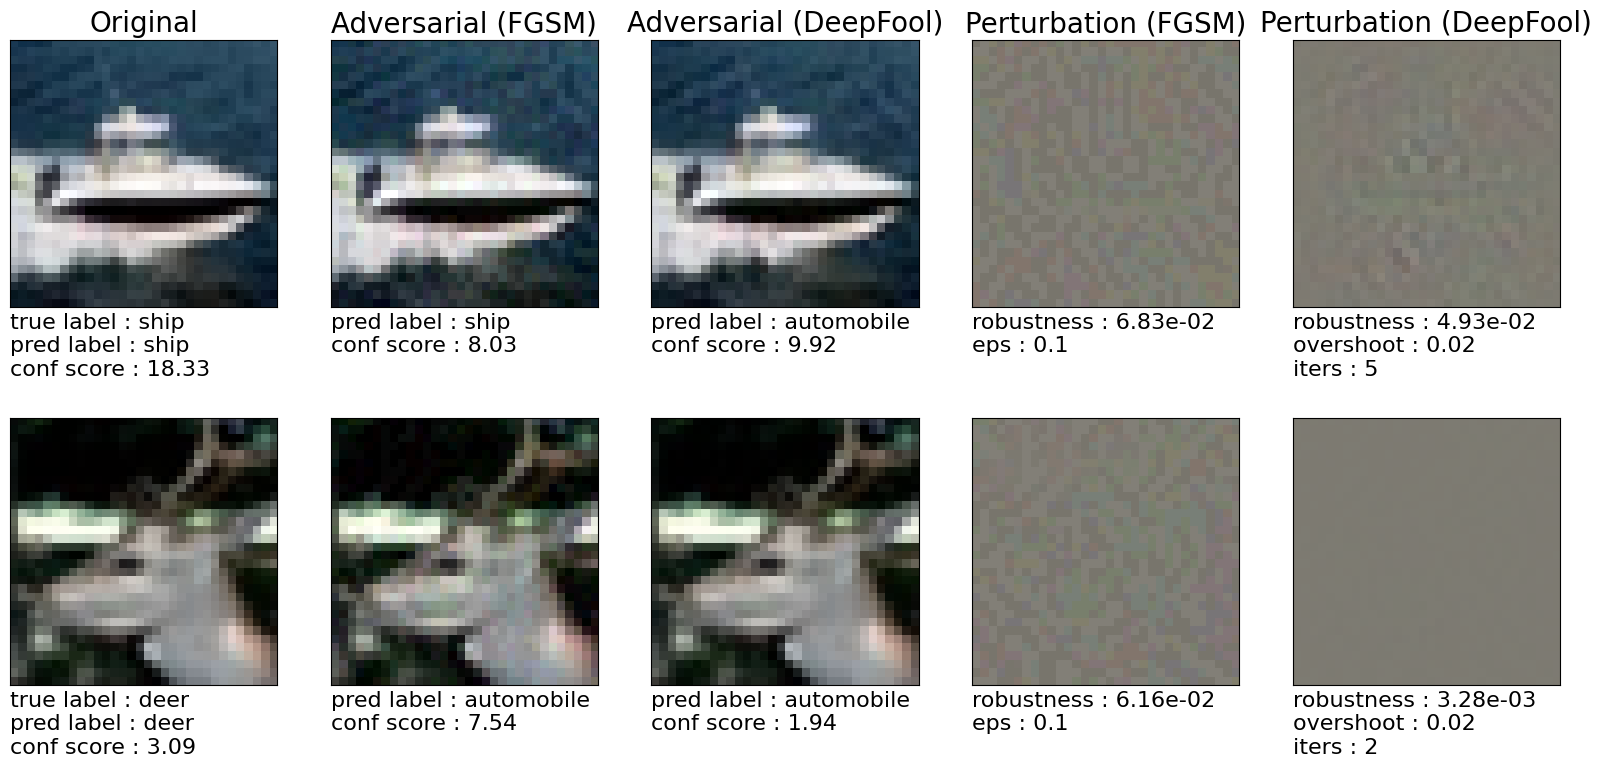

In [ ]:
# LeNet на датасете CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
if device.type == 'cuda':
  torch.cuda.empty_cache()

## **15. Теперь перейдем к перебору значений параметра `fgsm_eps_mass=(0.001, 0.02, 0.5, 0.9, 10)` и оценим влияние параметра `eps` для сетей FC и LeNet на датасете MNIST, а также NiN и LeNet на датасете CIFAR:**

In [ ]:
fgsm_eps_mass=[0.001, 0.02, 0.5, 0.9, 10]

### **15.1. Рассмотрим различные значения переменной eps и сравним ошибки нейросети (модель - NiN, датасет - CIFAR):**

In [ ]:
model = Net().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'cifar_nin_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  print('')
  if device.type == 'cuda':
    torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.35 s
FGSM Time (Per Image) : 134.62 us



fgsm eps =  0.02


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.07 s
FGSM Time (Per Image) : 106.92 us



fgsm eps =  0.5


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.65%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.20 s
FGSM Time (Per Image) : 119.75 us



fgsm eps =  0.9


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.60%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.10 s
FGSM Time (Per Image) : 110.27 us



fgsm eps =  10


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.53%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 112.55 us



**Вывод:** При значении eps <= 0.02 ошибка была довольно мала, 30% и 10%, а на 0.5 уже 82%, из чего можно сделать вывод что для удачной атаки значение eps находится где-то можду 0.02 и 0.5

#### **15.1.1 Рассмотрим, как значение переменной eps влияет на входные изображения при атаке FGSM и DeepFool:**



Отображение изображений для epsilon: 0.001


<ipython-input-19-ee82e9df5f9b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

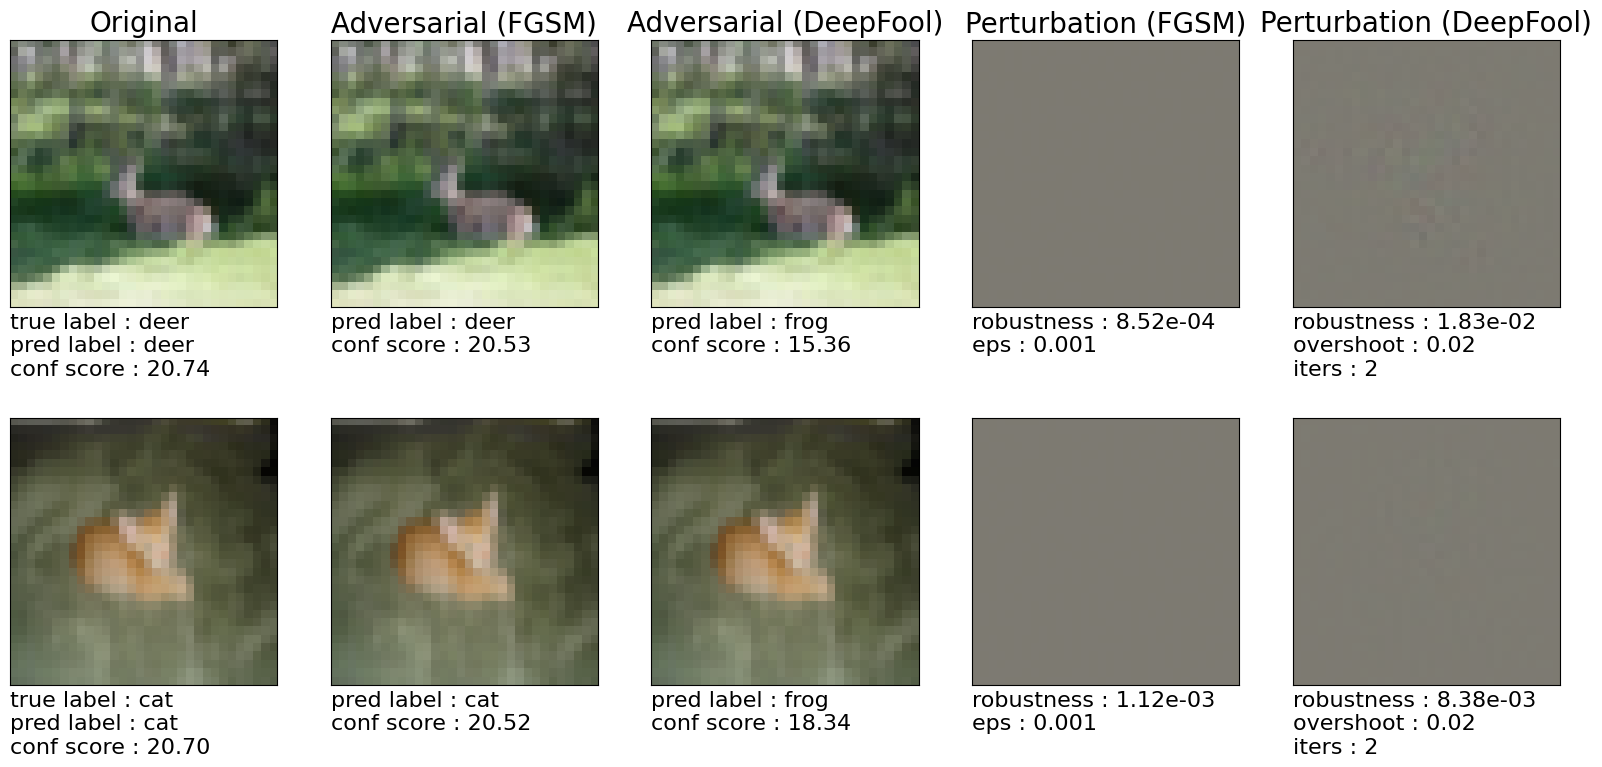



Отображение изображений для epsilon: 0.02


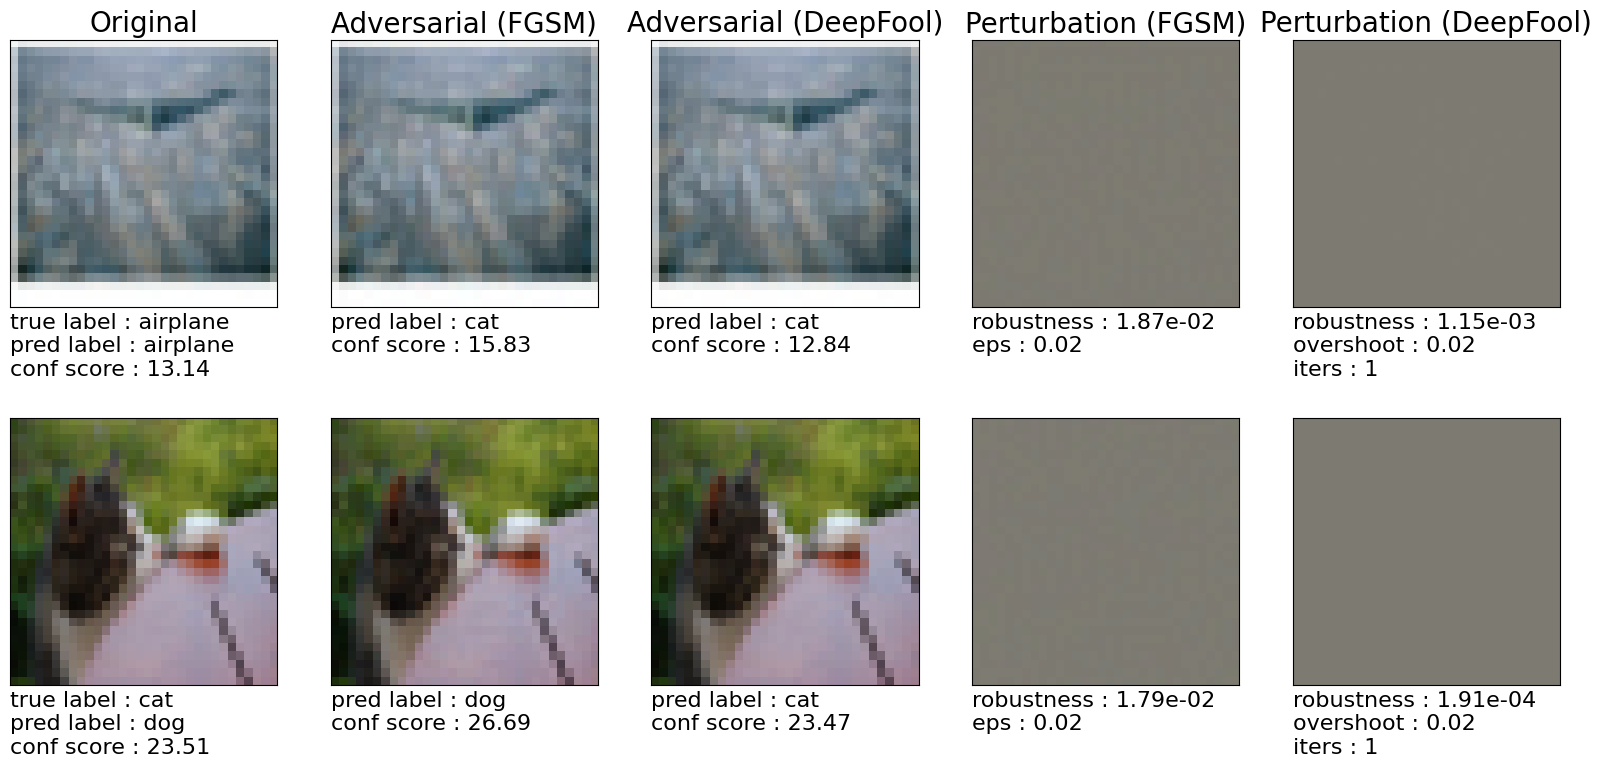



Отображение изображений для epsilon: 0.5


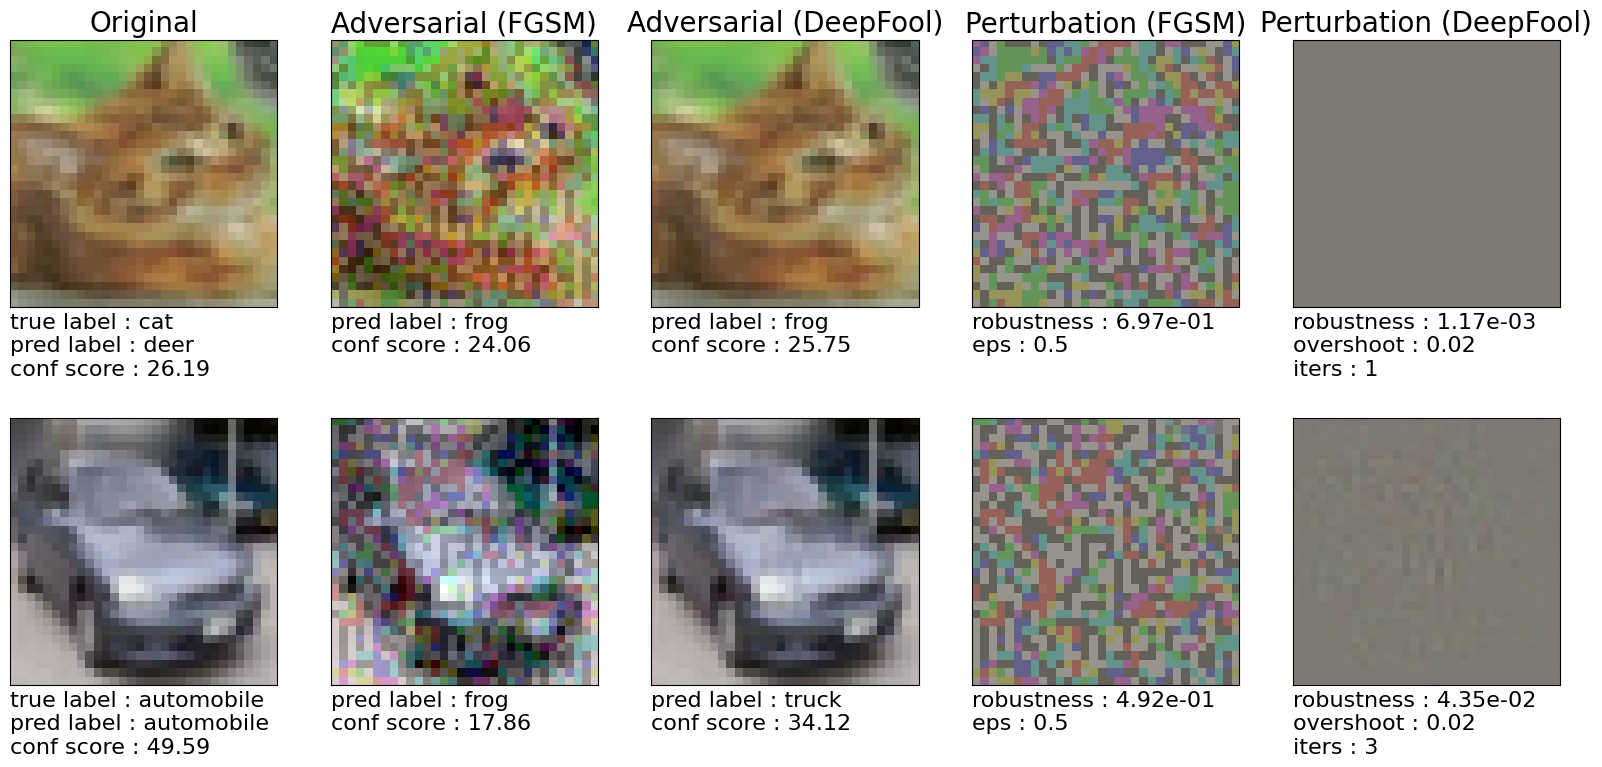



Отображение изображений для epsilon: 0.9


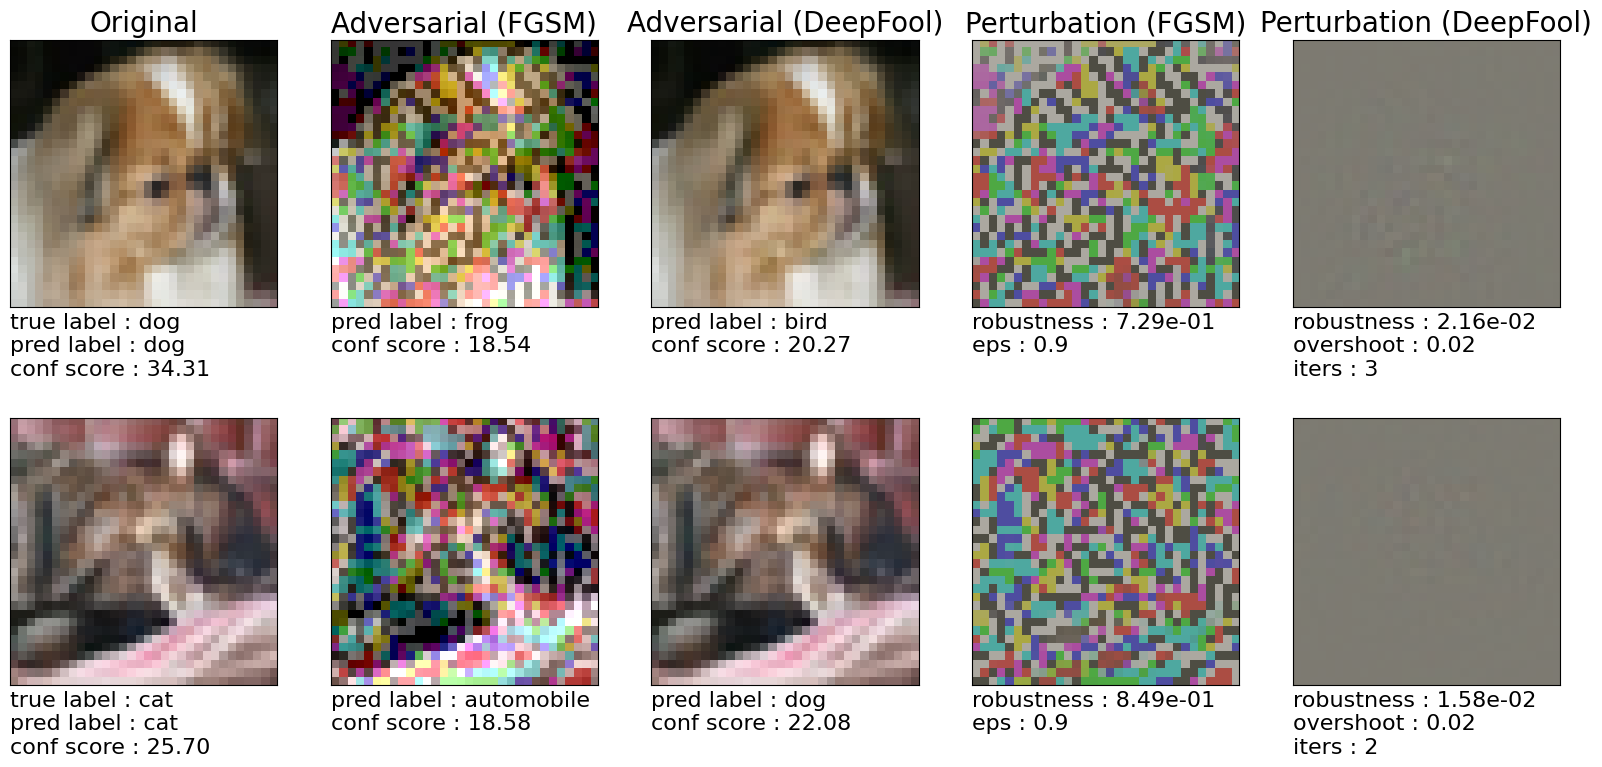



Отображение изображений для epsilon: 10


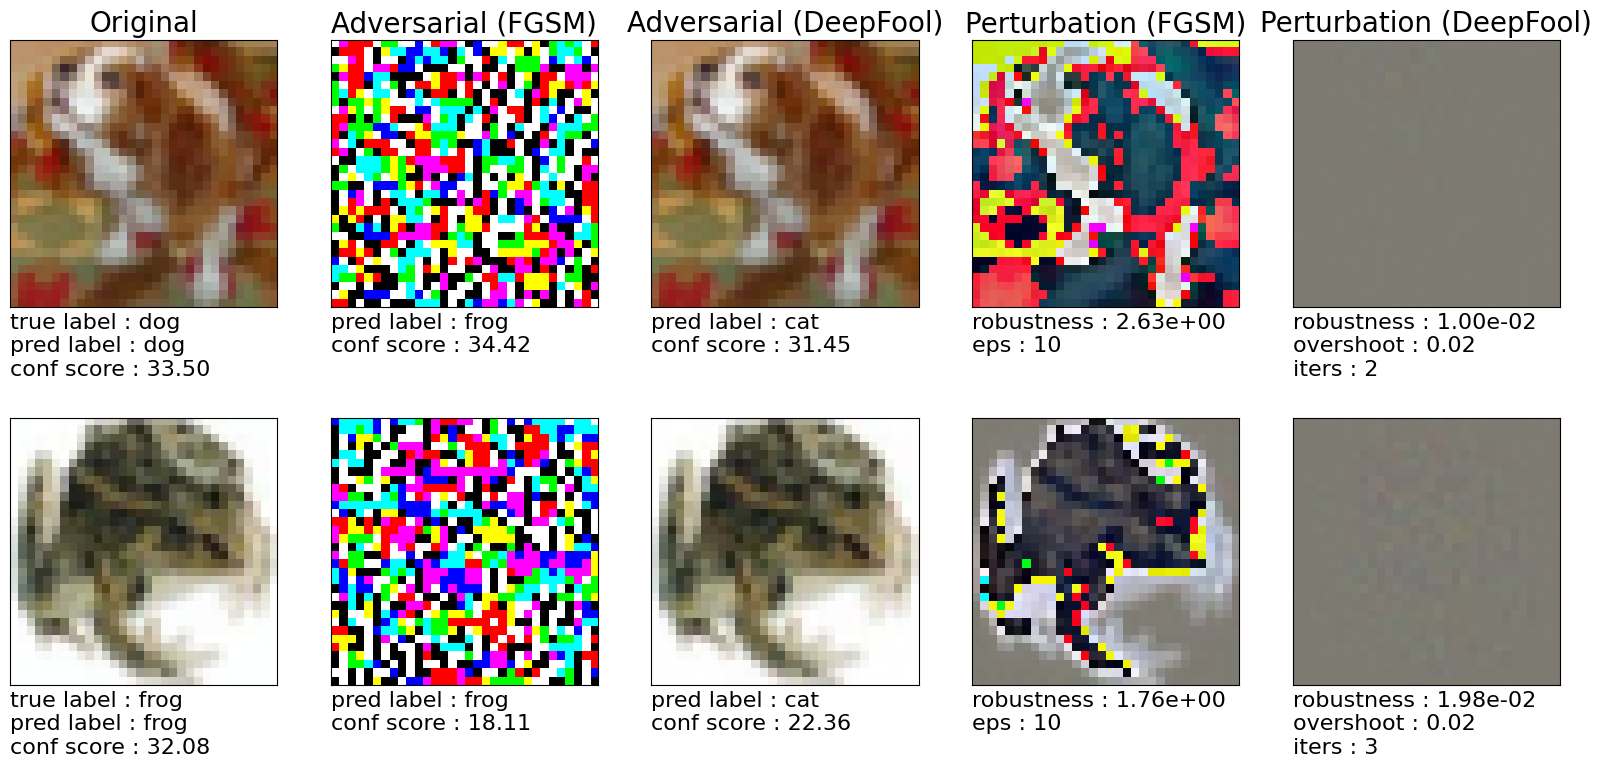

In [ ]:
model = Net().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Вывод:** значения меньше 0.1 почти не несут никаких искажений и незначительно ухудшают работу нейросети. Значение 0.5 уже заметно изменяет изображение

#### **15.1.2 Исходя из вышеперечисленного анализа, для успешной атаки возьмем значение переменной eps = 0.2**

fgsm eps =  0.2


<ipython-input-20-1666a699f991>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.11/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 112.59 us


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


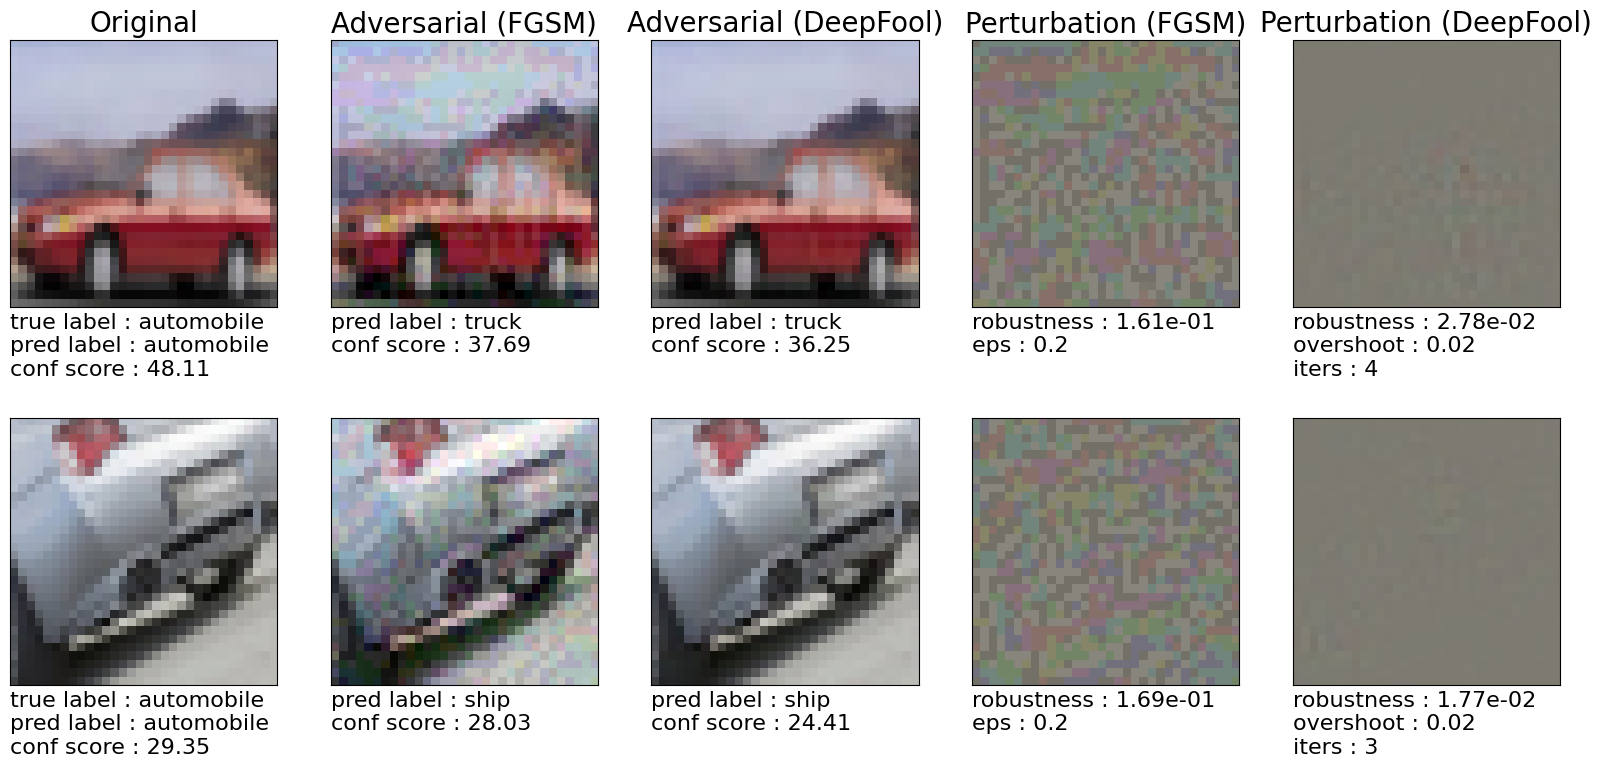

In [ ]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

print('fgsm eps = ', fgsm_eps)
filename = 'cifar_nin_fgsm' + str(fgsm_eps) + '.csv'
evaluate_attack(filename, 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

**Вывод:** Подобранное значение дает следующие результаты - искажения изображений почти не заметны, а ошибка составляет 81.29%.

### **15.2. Рассмотрим различные значения переменной eps и сравним ошибки нейросети (модель - LeNet, датасет - CIFAR):**

In [ ]:
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'cifar_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, cifar_loader_test,
                  cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-21-48c32ce70303>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.11

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 22.73%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.15 s
FGSM Time (Per Image) : 114.76 us


fgsm eps =  0.02


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 47.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.16 s
FGSM Time (Per Image) : 116.37 us


fgsm eps =  0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 95.18%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.10 s
FGSM Time (Per Image) : 109.54 us


fgsm eps =  0.9


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 92.07%
FGSM Robustness : 7.80e-01
FGSM Time (All Images) : 1.38 s
FGSM Time (Per Image) : 138.28 us


fgsm eps =  10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 89.87%
FGSM Robustness : 2.47e+00
FGSM Time (All Images) : 1.04 s
FGSM Time (Per Image) : 103.57 us


**Вывод:** До значения eps = 0.5 ситация напоминает нам прошлый эксперимент. однако при eps > 0.5 ошибка наоборот начинает уменьшаться

#### **15.2.1 Рассмотрим, как значение переменной eps влияет на входные изображения при атаке FGSM и DeepFool:**



Отображение изображений для epsilon: 0.001


<ipython-input-22-030d213b8a7c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.11

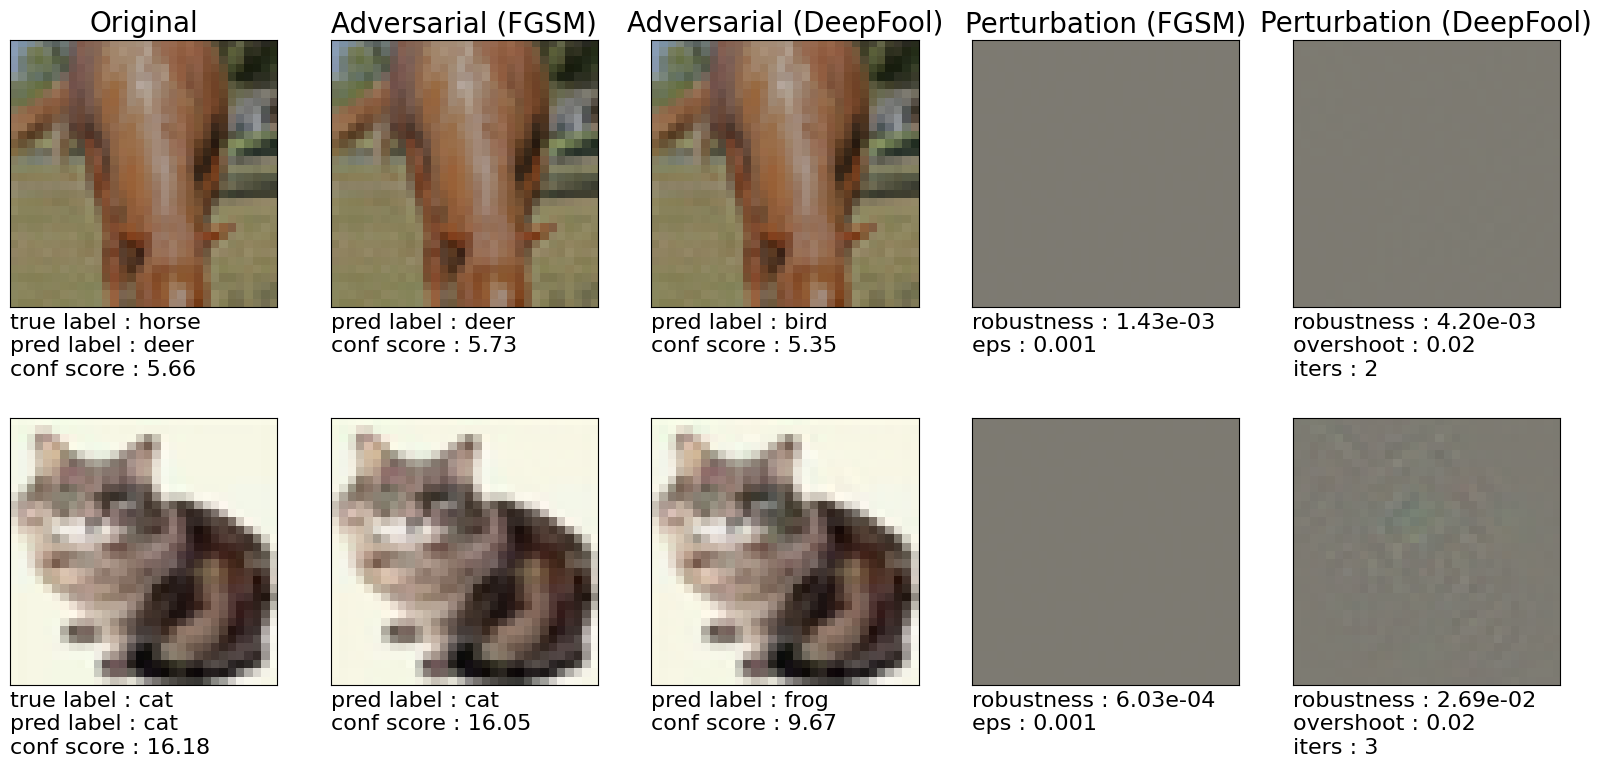



Отображение изображений для epsilon: 0.02


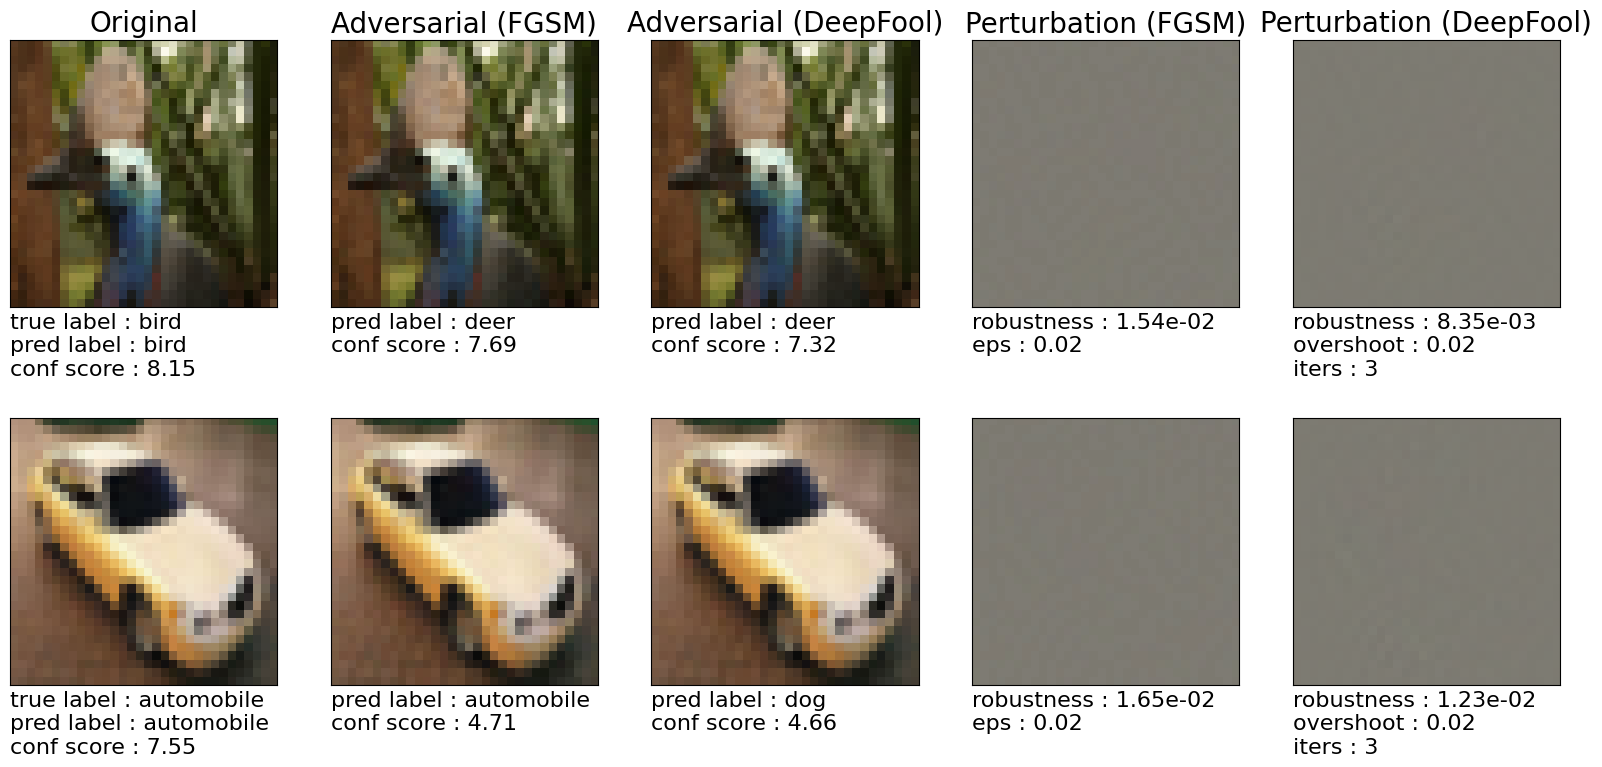



Отображение изображений для epsilon: 0.5


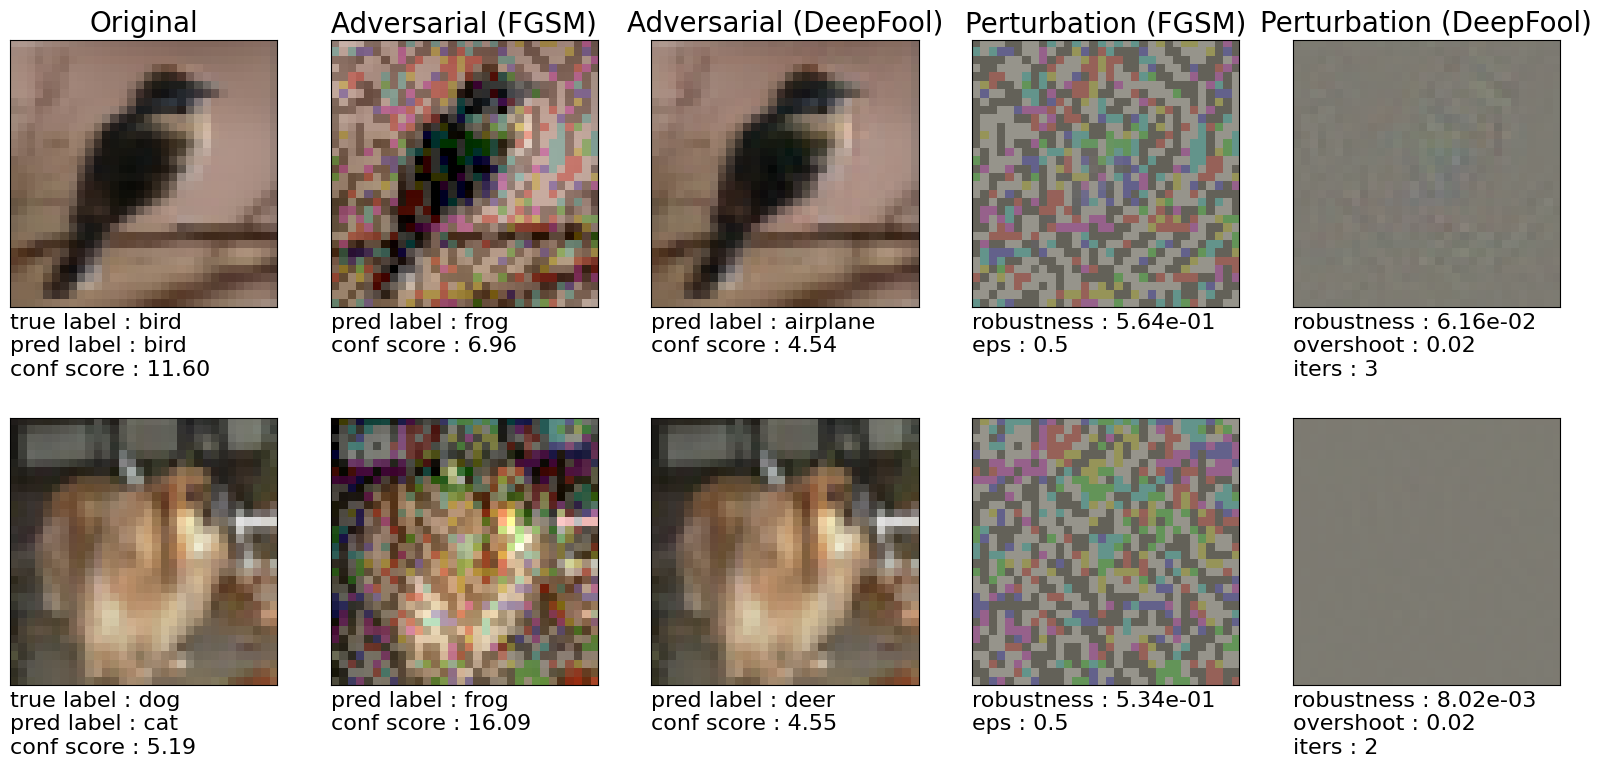



Отображение изображений для epsilon: 0.9


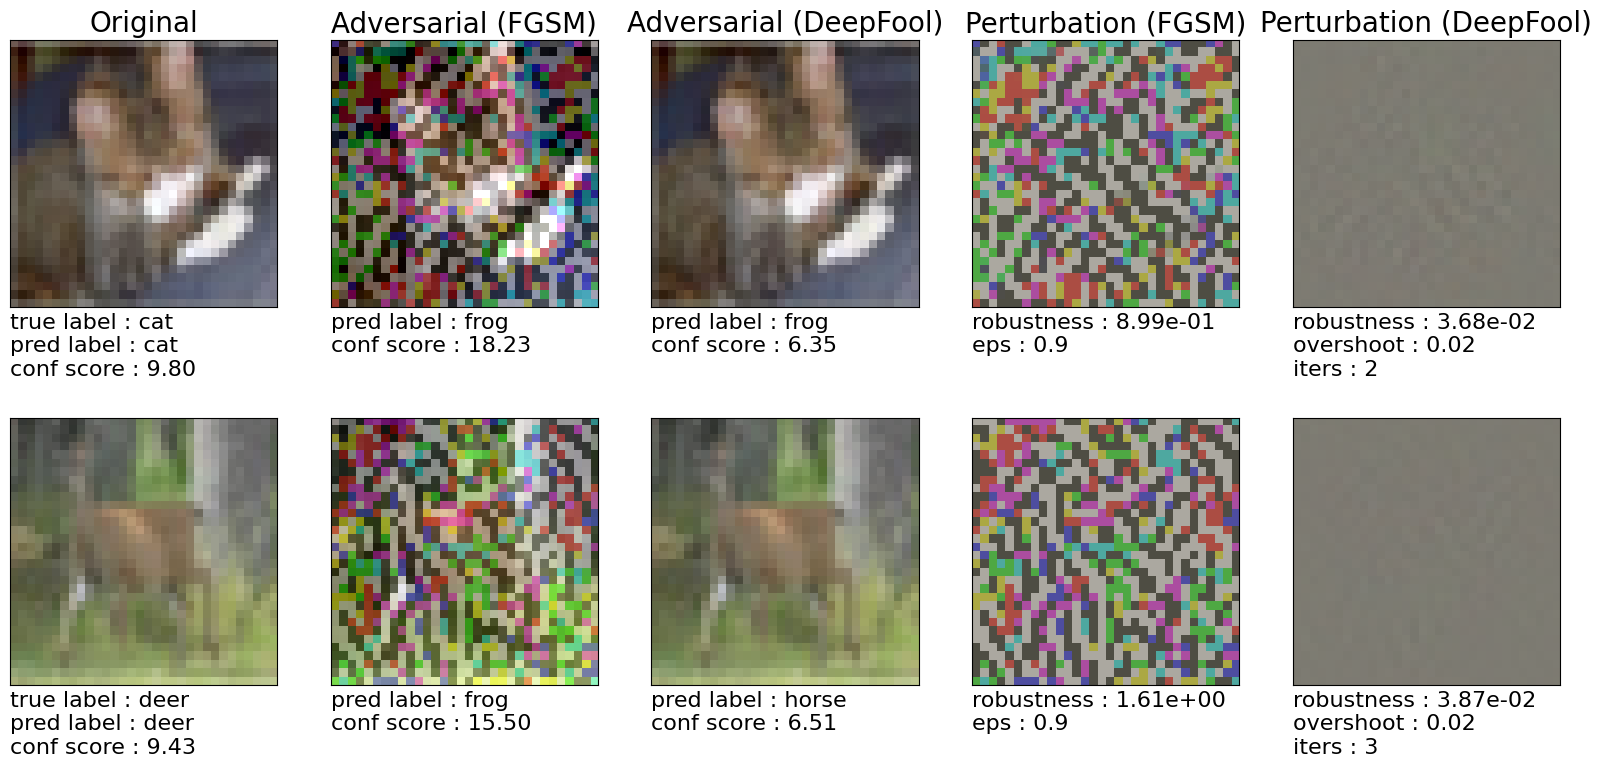



Отображение изображений для epsilon: 10


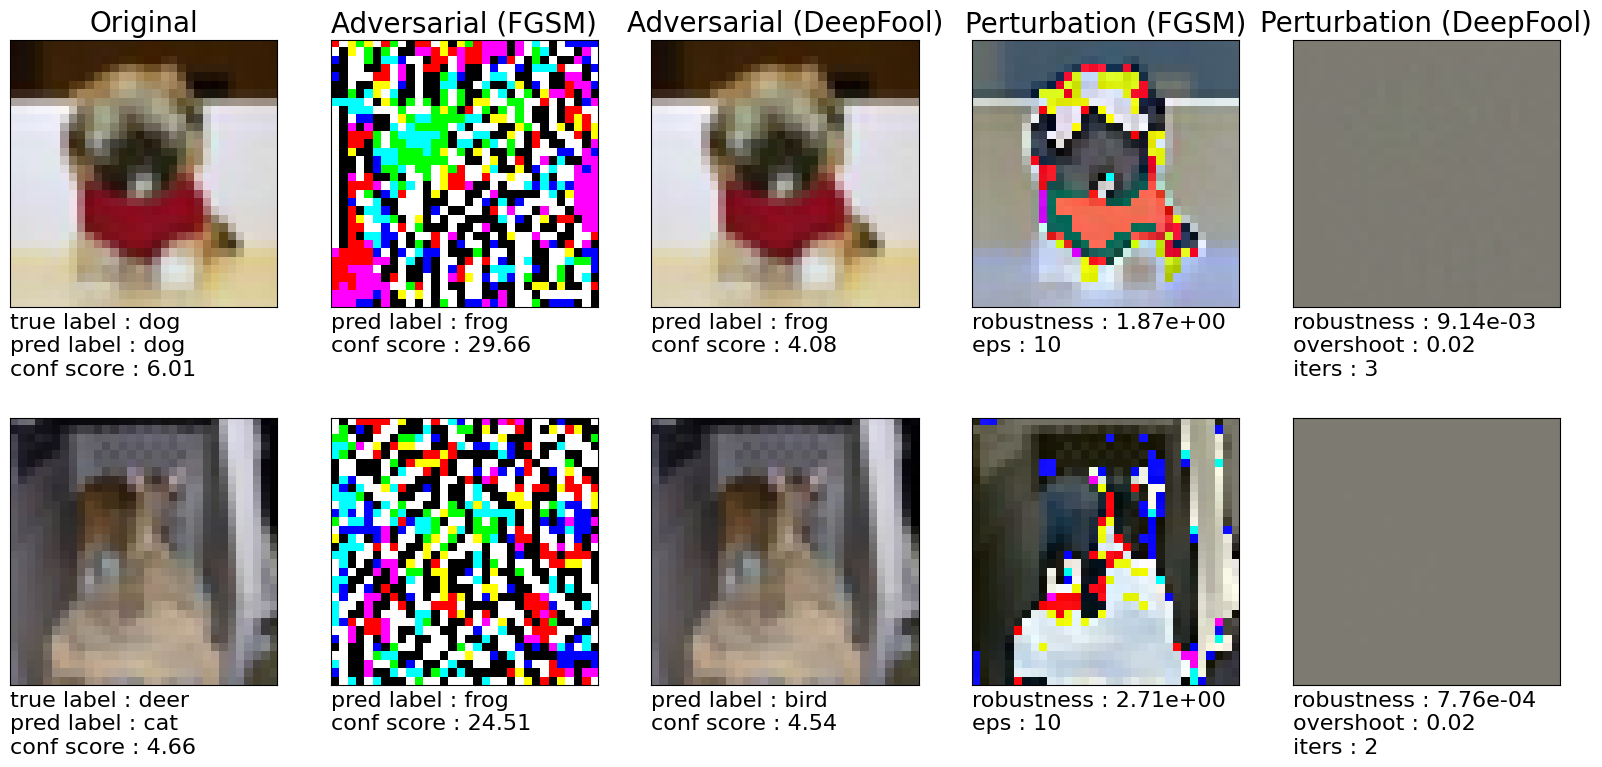

In [ ]:
model = LeNet_CIFAR().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Вывод:** Аналогичнено прошлому эксперименту - значения меньше 0.1 почти не несут никаких искажений и незначительно ухудшают работу нейросети. Значение 0.5 и более уже заметно изменяют изображение

#### **15.2.2 Исходя из вышеперечисленного анализа, для успешной атаки возьмем значение переменной eps = 0.1**

fgsm eps =  0.1


<ipython-input-23-9ab227da7d58>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.11

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 1.09 s
FGSM Time (Per Image) : 109.25 us


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


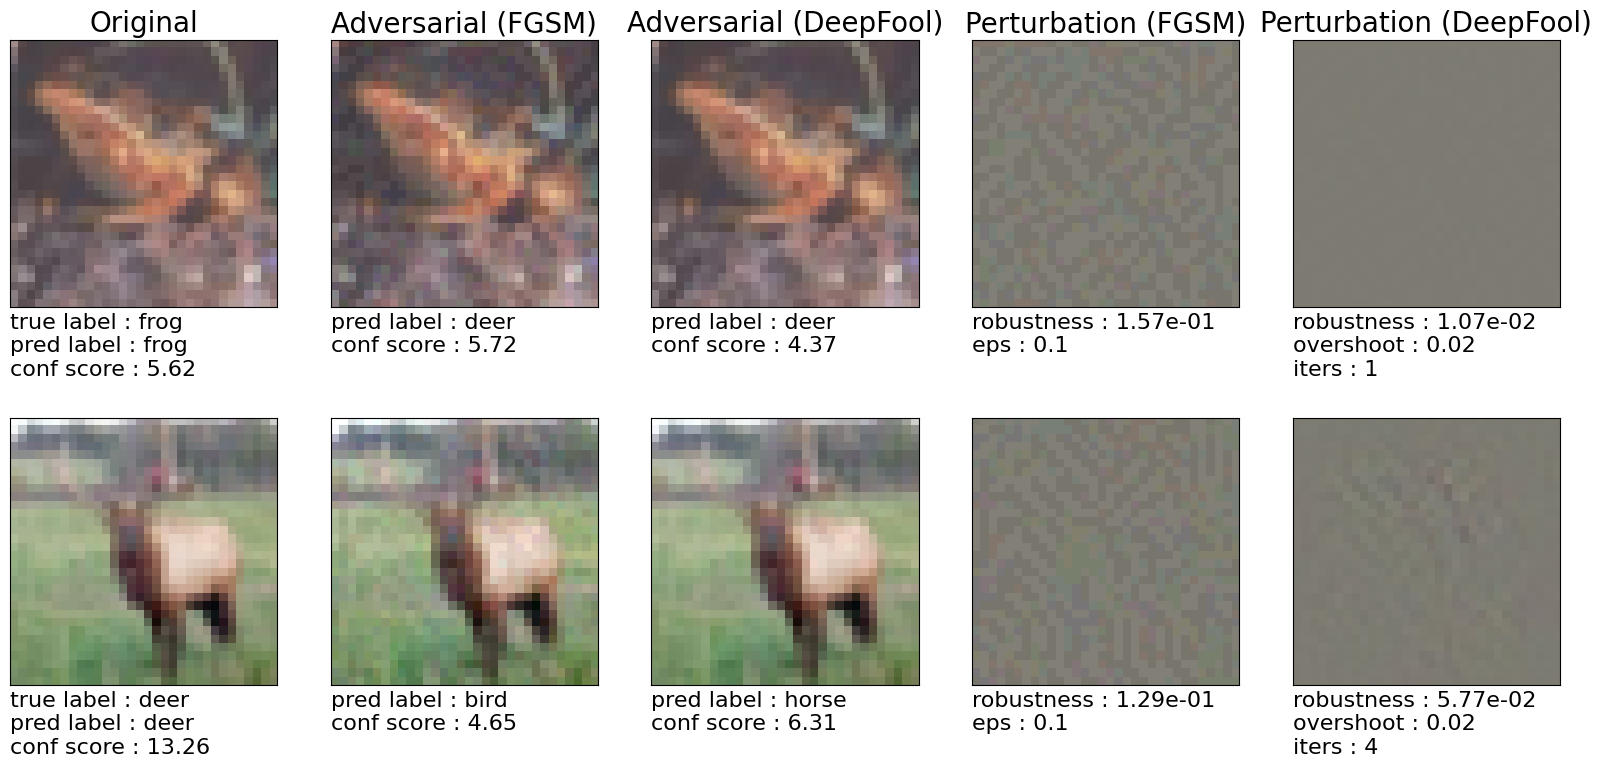

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

print('fgsm eps = ', fgsm_eps)
filename = 'cifar_lenet_fgsm' + str(fgsm_eps) + '.csv'
evaluate_attack(filename, 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

**Вывод:** При выбранном значении eps = 0.1 искажения минимальны, а ошибка составляет 91.71%.

### **15.3. Рассмотрим различные значения переменной eps и сравним ошибки нейросети (модель - FC, датасет - MNIST):**

In [ ]:
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-24-a6534b2eec4c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.11/di

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.63 s
FGSM Time (Per Image) : 62.67 us


fgsm eps =  0.02


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.52 s
FGSM Time (Per Image) : 52.19 us


fgsm eps =  0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.51 s
FGSM Time (Per Image) : 51.31 us


fgsm eps =  0.9


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.66 s
FGSM Time (Per Image) : 66.04 us


fgsm eps =  10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.79 s
FGSM Time (Per Image) : 79.03 us


**Вывод:** До значения eps = 0.5 процент ошибки растет медленно, а вот в значении равном 0.5 резко увеличивается до 99%

#### **15.3.1 Рассмотрим, как значение переменной eps влияет на входные изображения при атаке FGSM и DeepFool:**



Отображение изображений для epsilon: 0.001


<ipython-input-25-4a0088952667>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.11/di

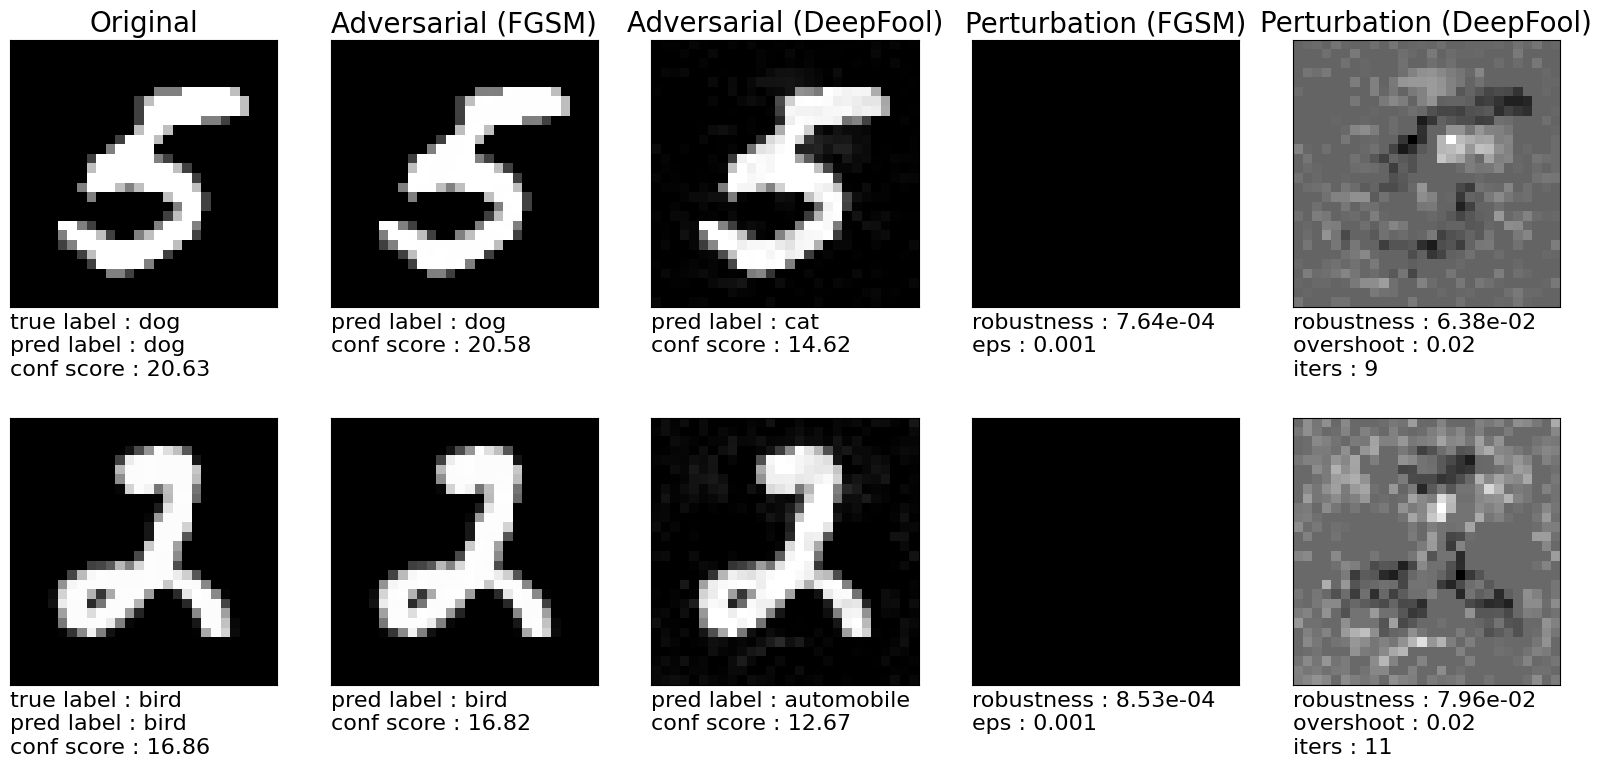



Отображение изображений для epsilon: 0.02


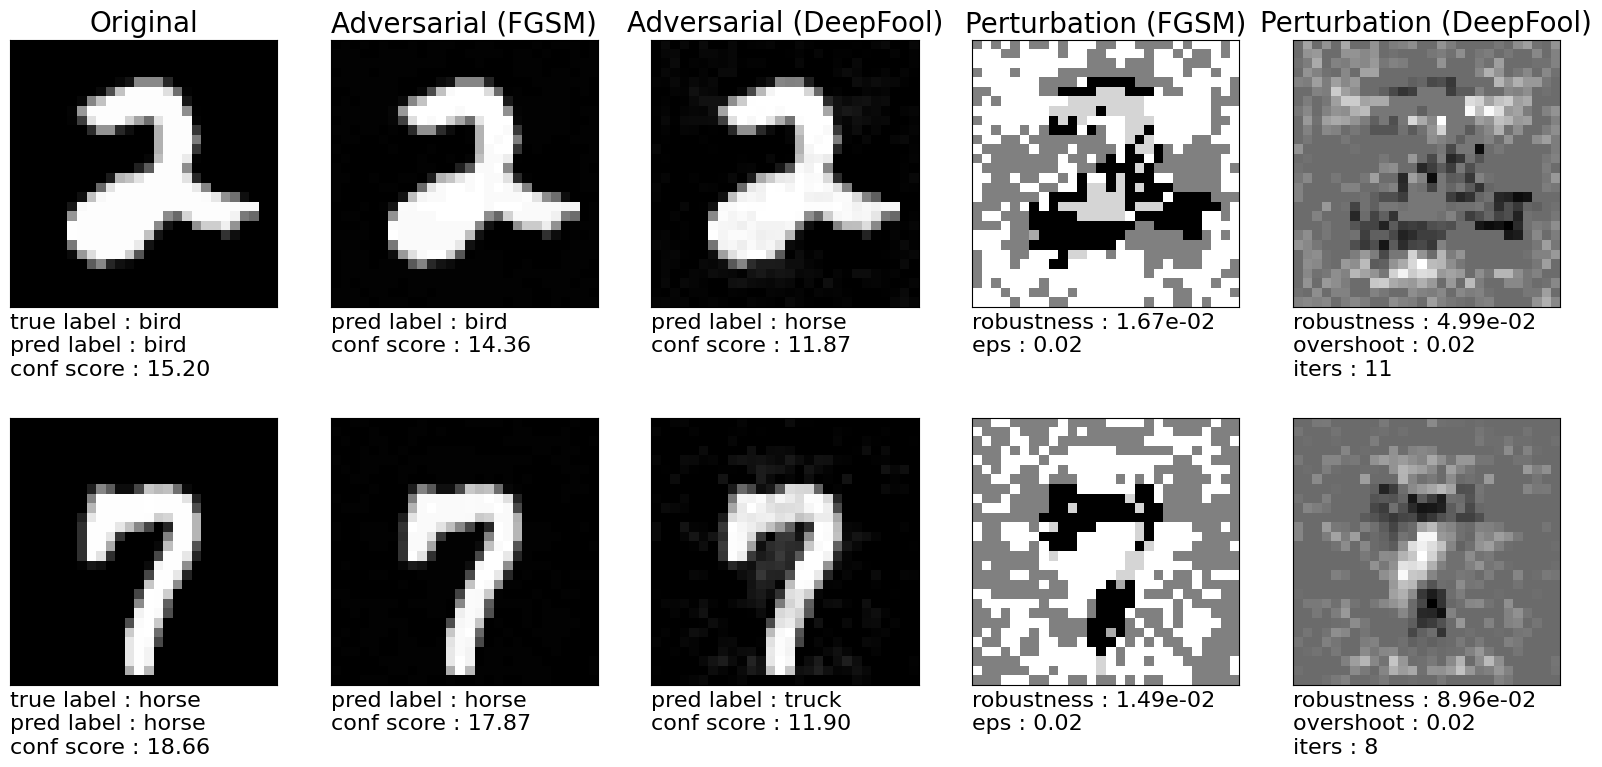



Отображение изображений для epsilon: 0.5


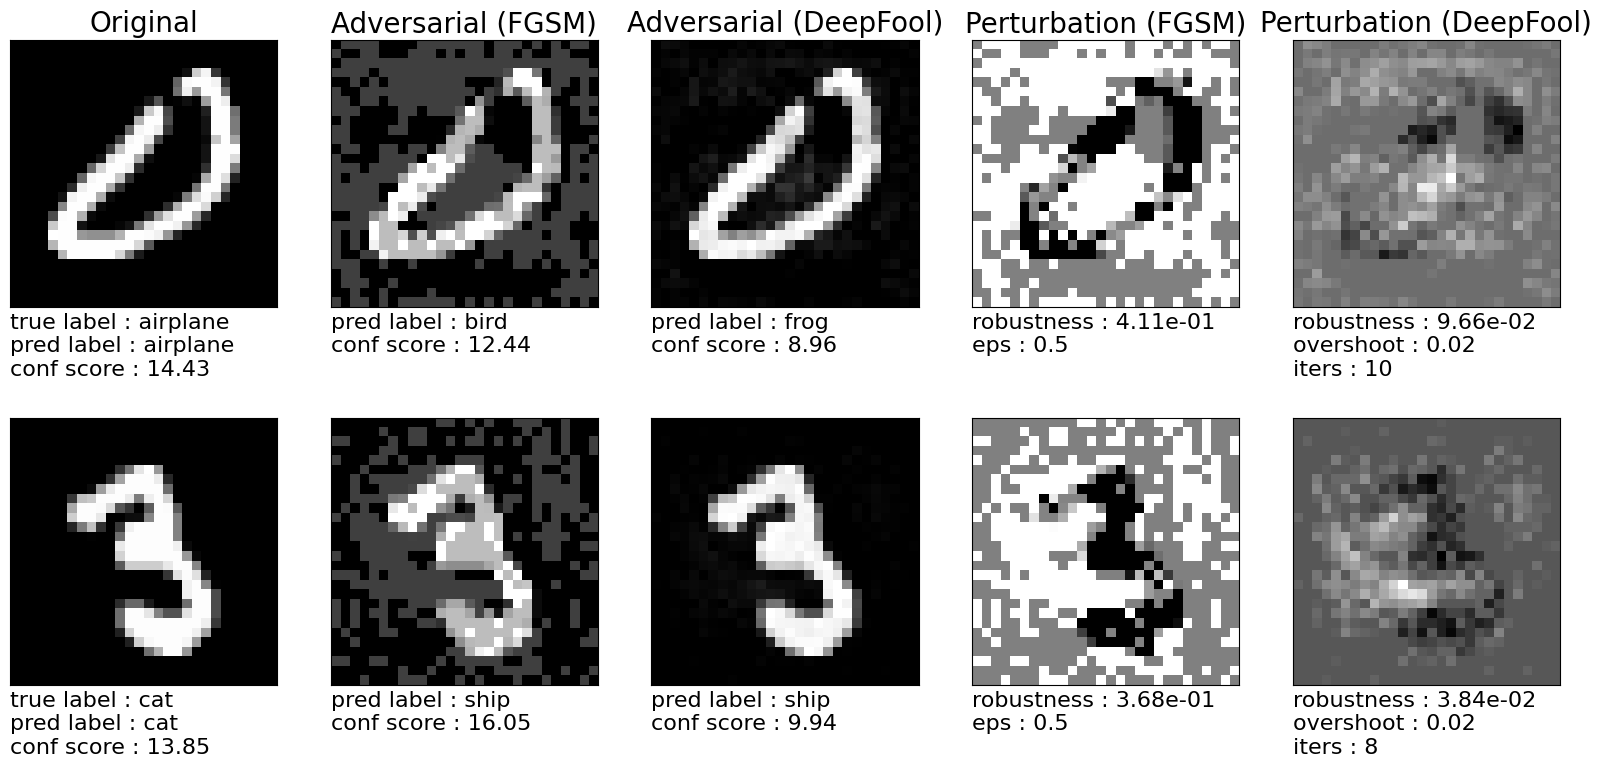



Отображение изображений для epsilon: 0.9


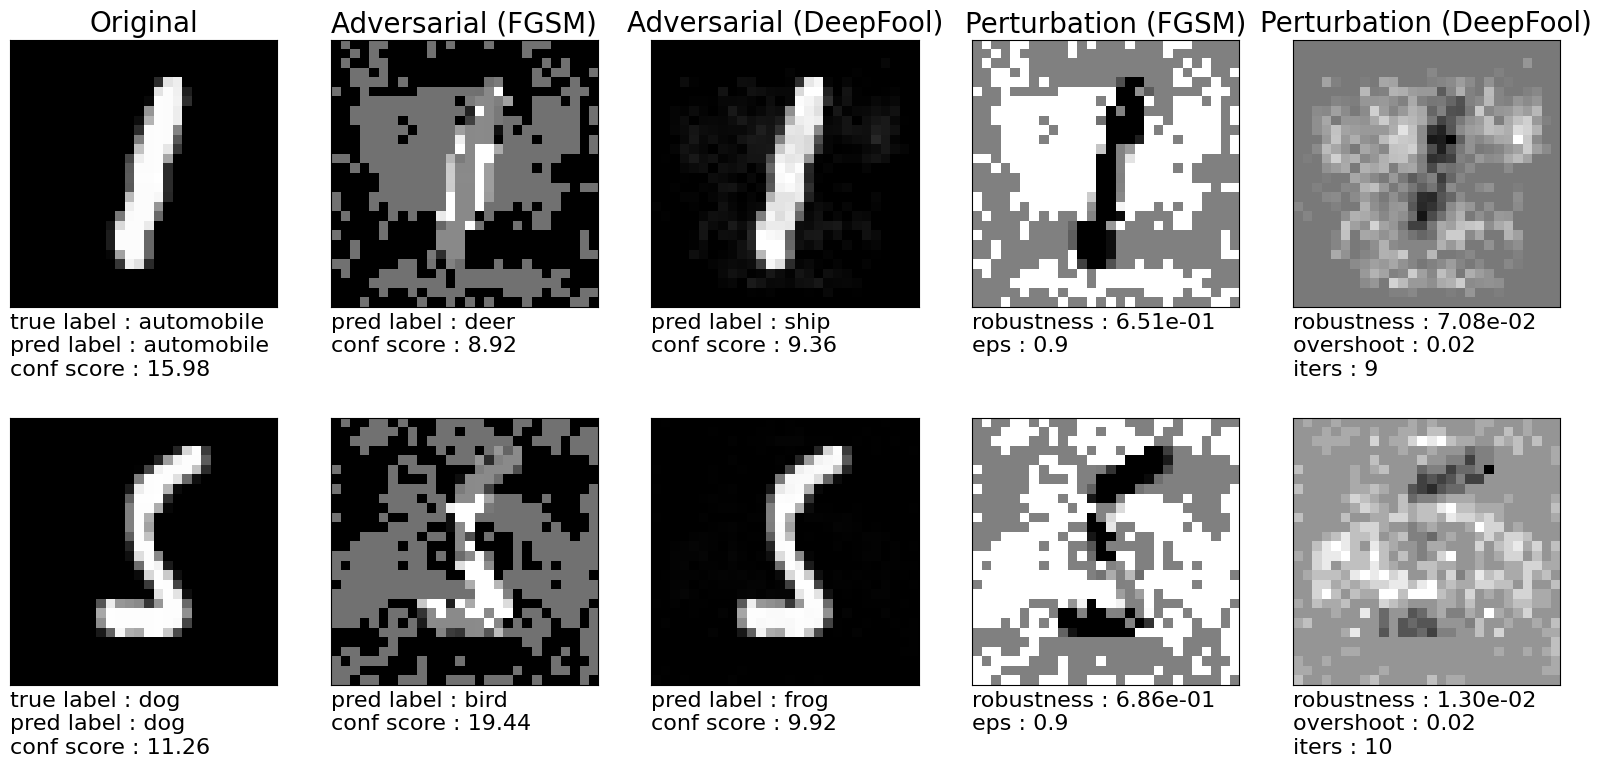



Отображение изображений для epsilon: 10


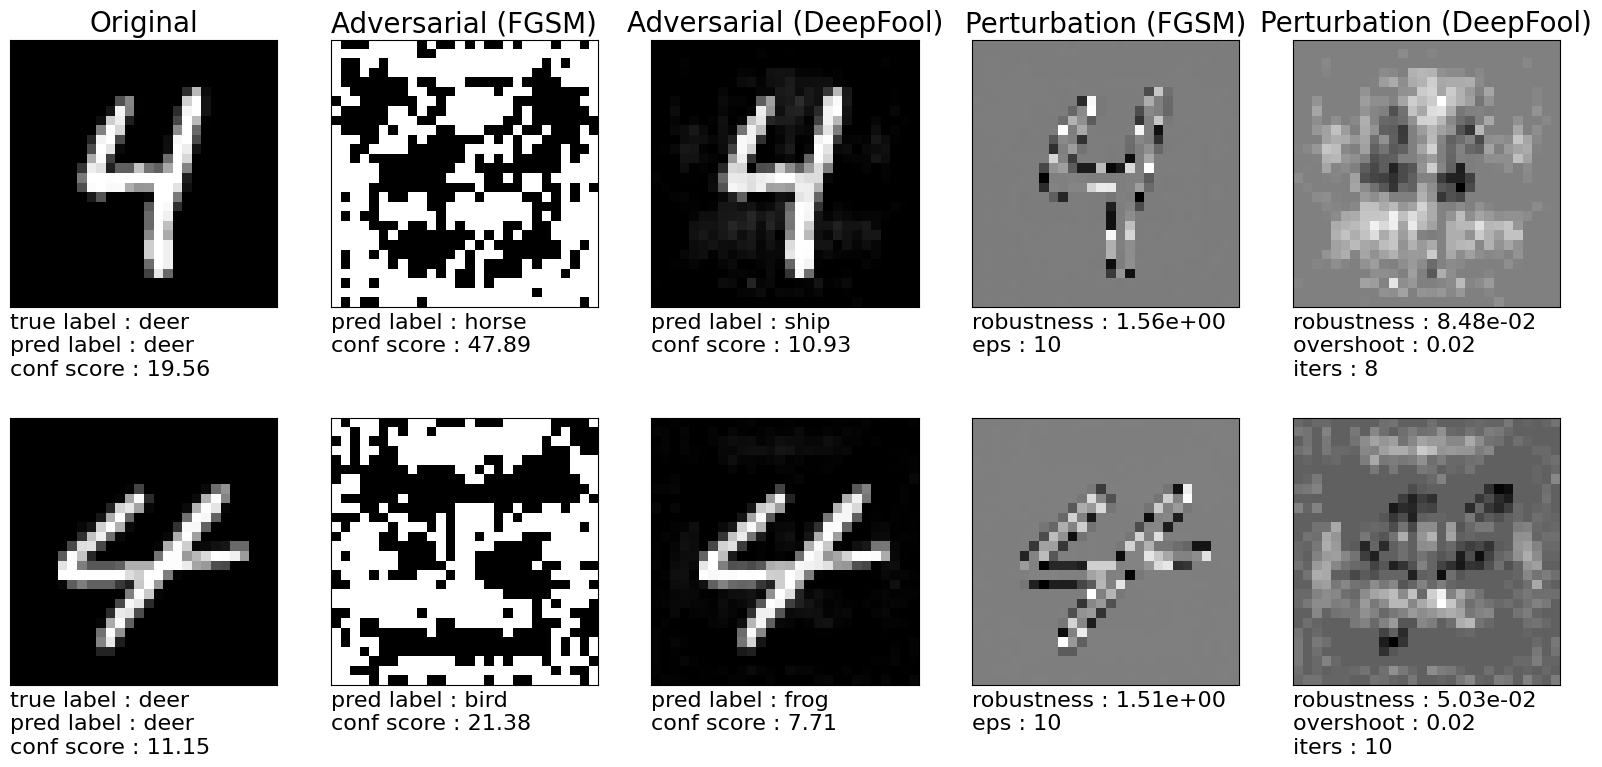

In [ ]:
model = FC_500_150().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Вывод:** Как и в первых двух экспериментах слишком большие значения eps приводят к сильно искажённым изображениям, особенно когда значение параметра превышает 0.5

#### **15.3.2 Исходя из вышеперечисленного анализа, для успешной атаки возьмем значение переменной eps = 0.2**

fgsm eps =  0.2


<ipython-input-26-43c898b702a3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.11/di

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.53 s
FGSM Time (Per Image) : 52.70 us


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


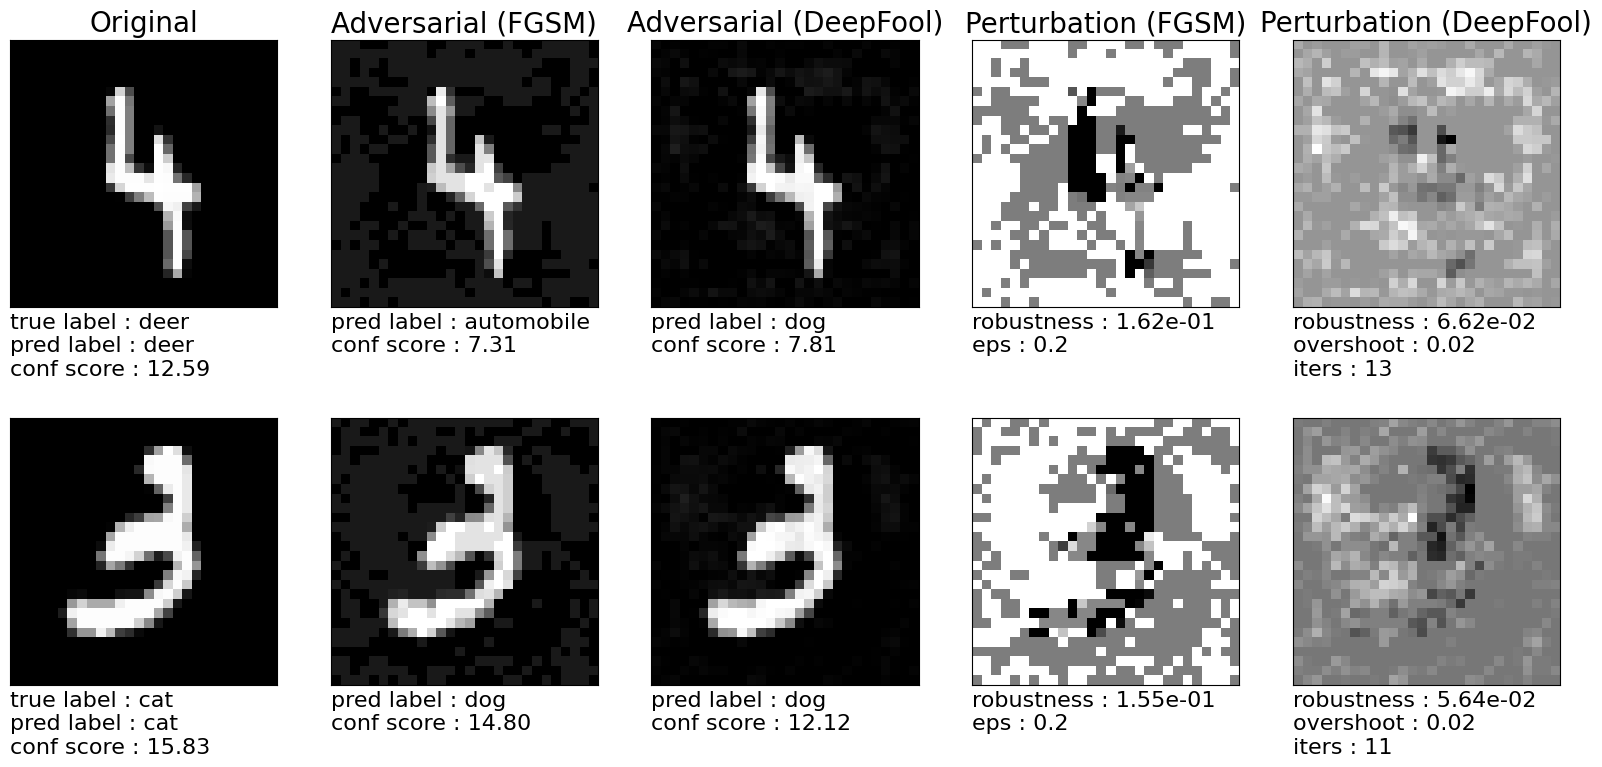

In [ ]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

print('fgsm eps = ', fgsm_eps)
filename = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

**Вывод:** При eps=0.2 искажения практически незаметны, а ошибка составляет до 87.08%

### **15.4. Рассмотрим различные значения переменной eps и сравним ошибки нейросети (модель - LeNet , датасет - MNIST):**

In [ ]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-27-925e00cbcba6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.11

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 1.69%
FGSM Robustness : 8.06e-04
FGSM Time (All Images) : 0.90 s
FGSM Time (Per Image) : 90.31 us


fgsm eps =  0.02


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 2.57%
FGSM Robustness : 1.59e-02
FGSM Time (All Images) : 0.94 s
FGSM Time (Per Image) : 93.88 us


fgsm eps =  0.5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 83.20%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 1.09 s
FGSM Time (Per Image) : 109.18 us


fgsm eps =  0.9


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 93.94%
FGSM Robustness : 6.81e-01
FGSM Time (All Images) : 0.89 s
FGSM Time (Per Image) : 88.74 us


fgsm eps =  10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 94.03%
FGSM Robustness : 1.46e+00
FGSM Time (All Images) : 0.87 s
FGSM Time (Per Image) : 86.60 us


**Вывод:** До значения eps = 0.5 процент ошибки растет также медленно, как и в прошлом эксперименте, а вот в значении равном 0.5 резко увеличивается до 83% и продолжает расти

#### **15.4.1 Рассмотрим, как значение переменной eps влияет на входные изображения при атаке FGSM и DeepFool:**



Отображение изображений для epsilon: 0.001


<ipython-input-28-40e3033c4b5a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.11

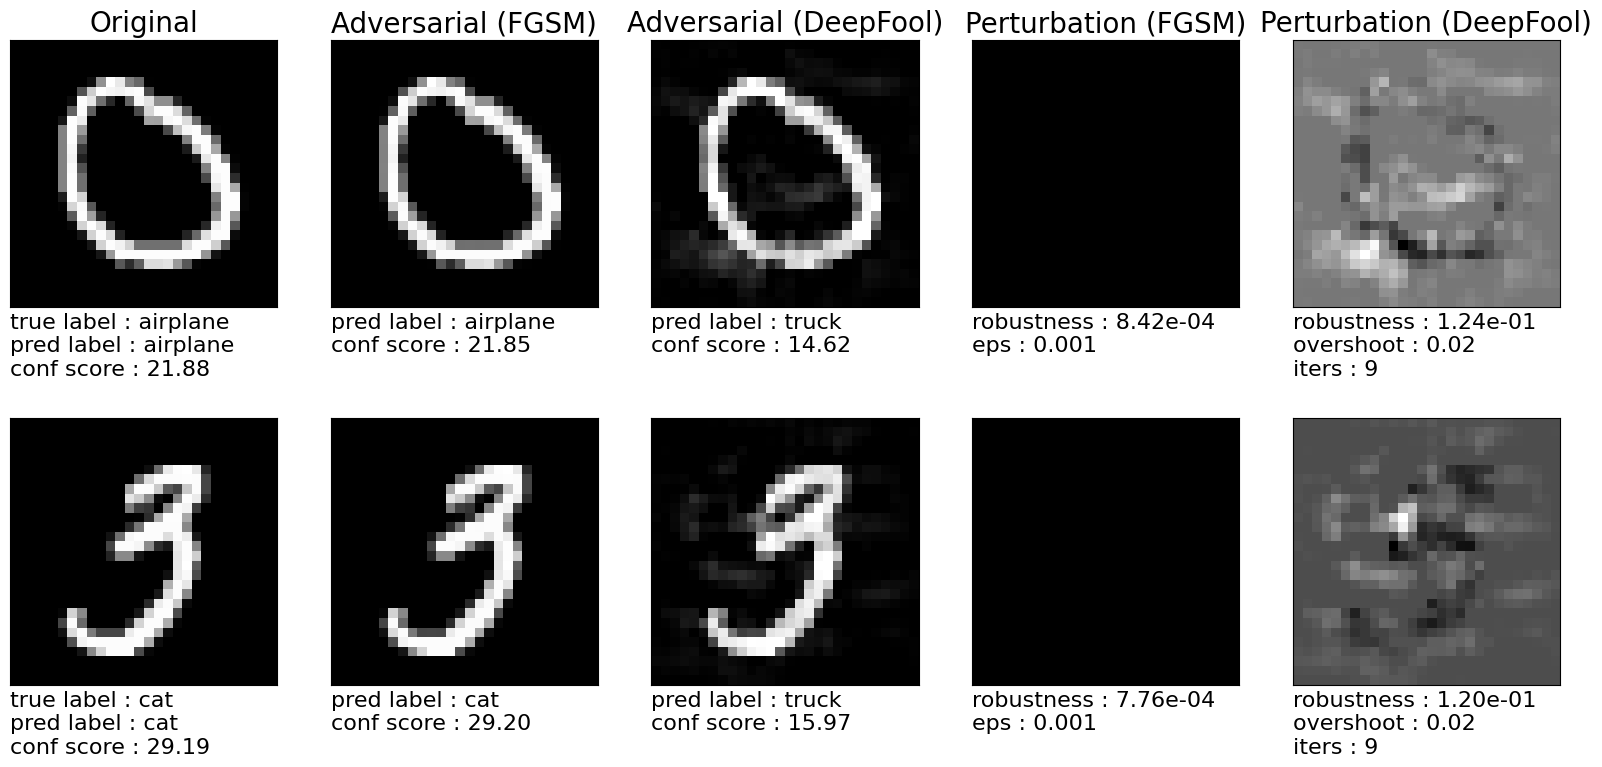



Отображение изображений для epsilon: 0.02


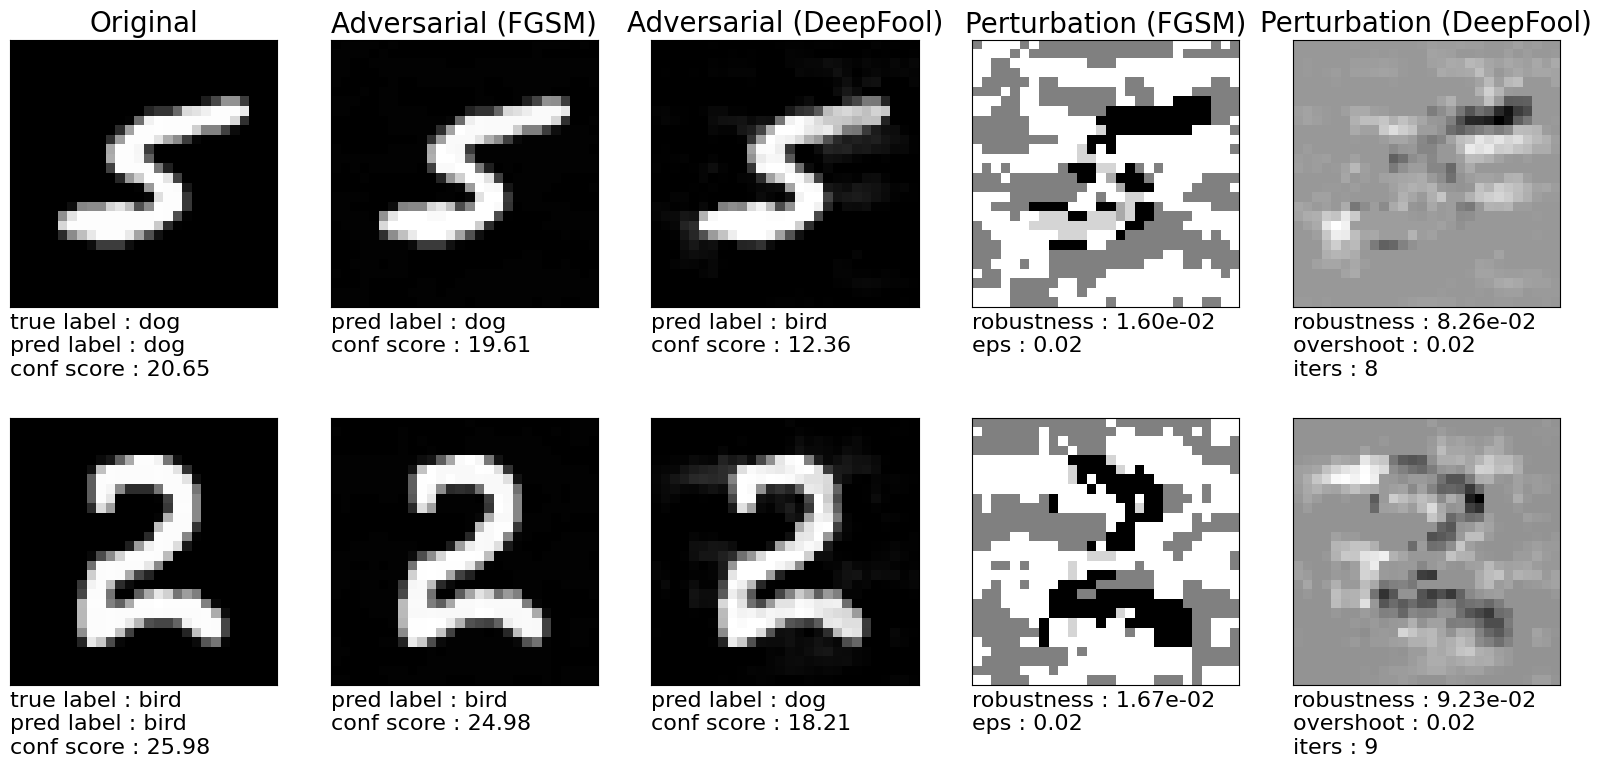



Отображение изображений для epsilon: 0.5


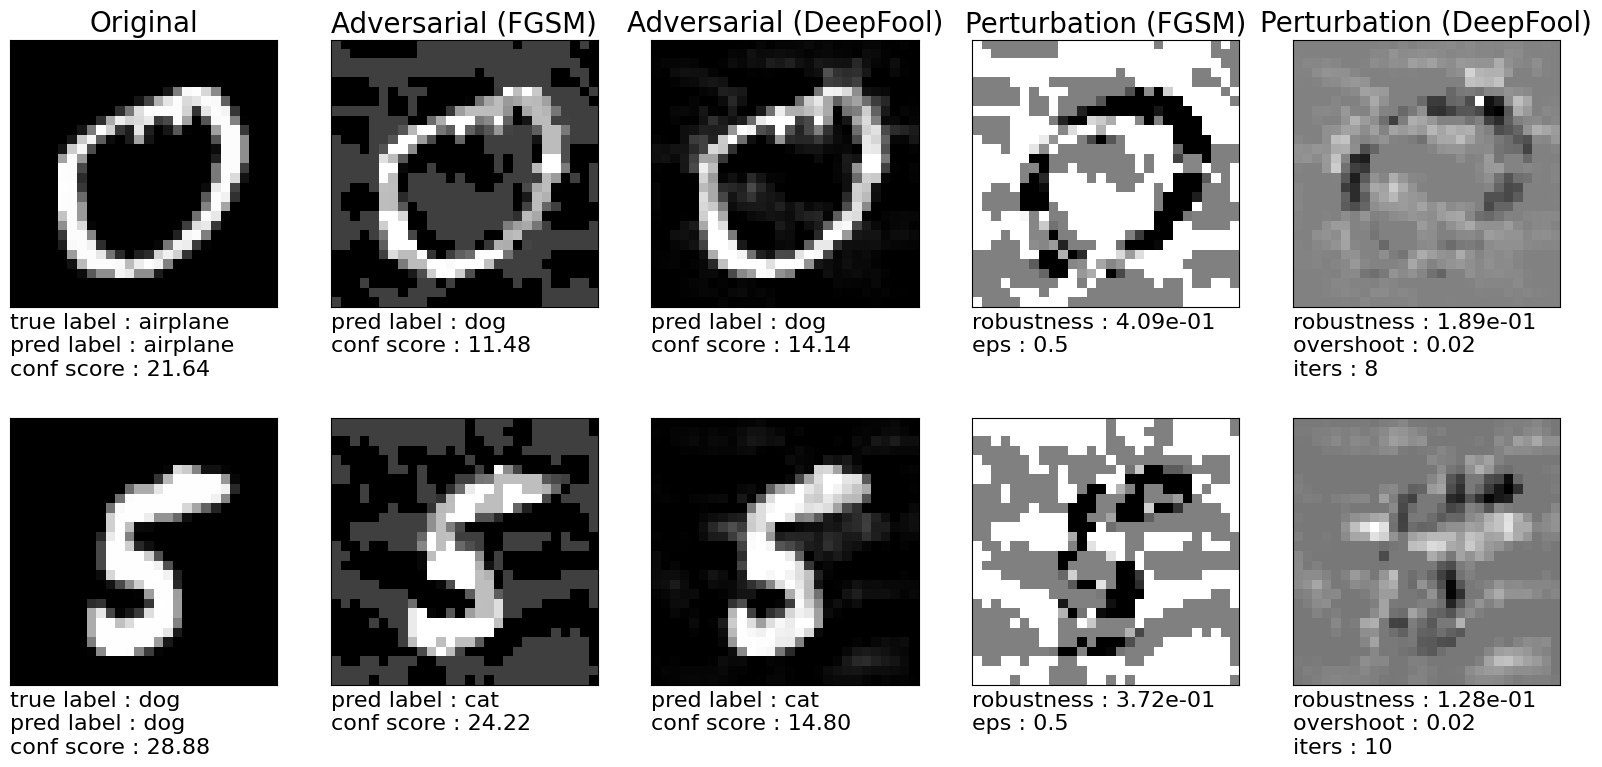



Отображение изображений для epsilon: 0.9


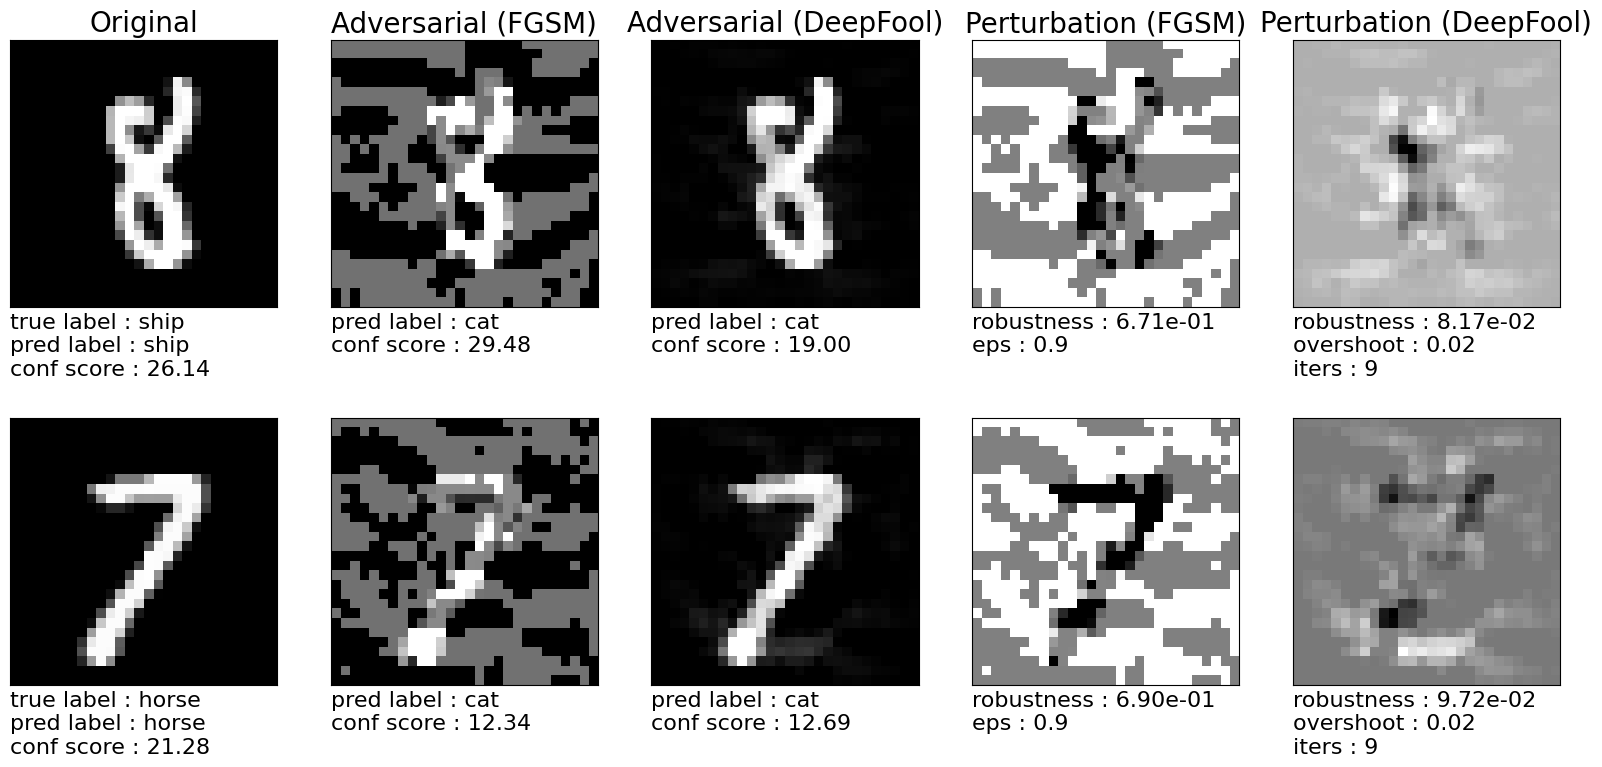



Отображение изображений для epsilon: 10


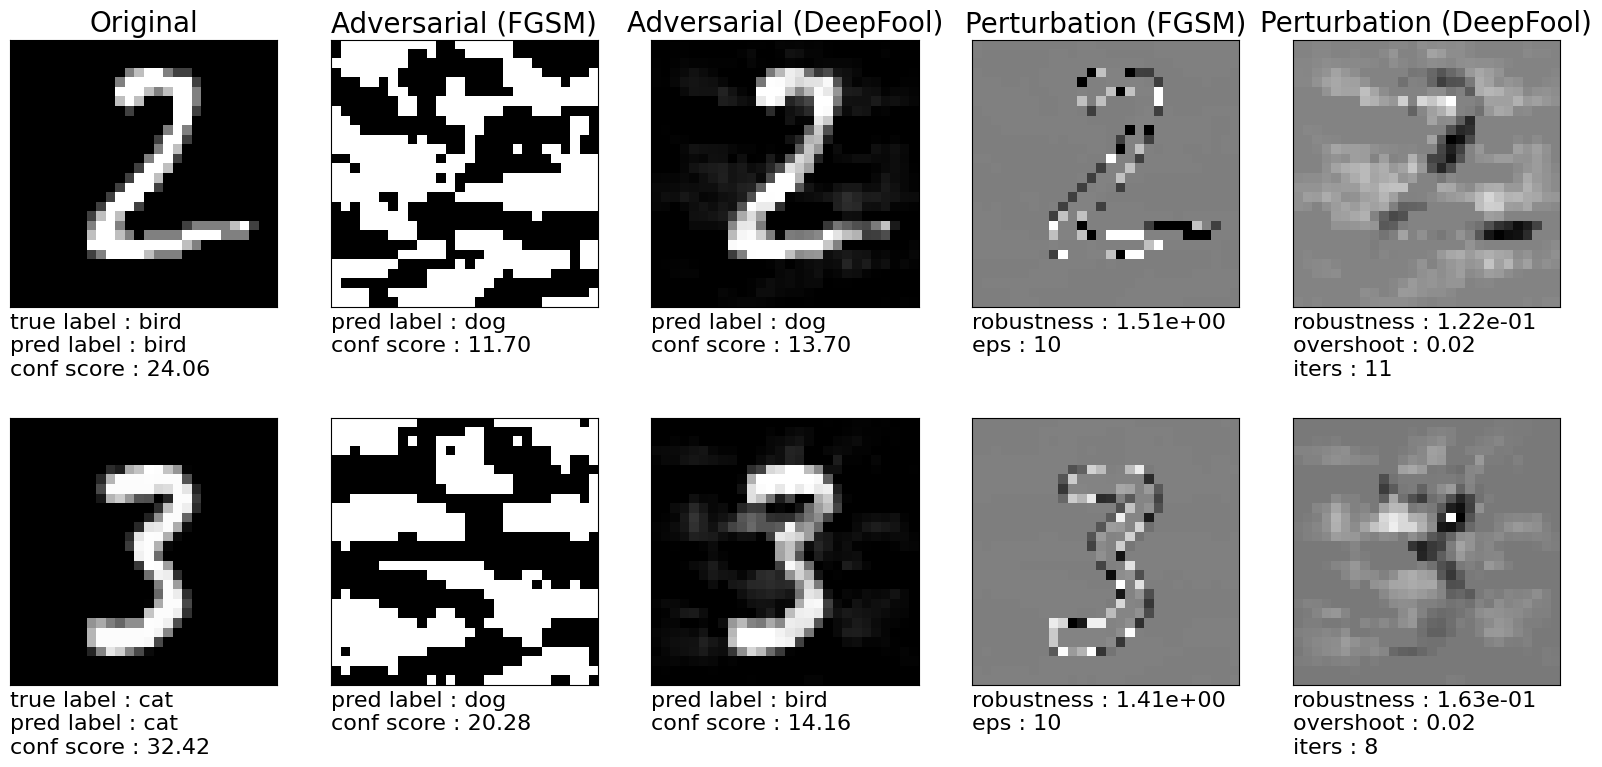

In [ ]:
model = LeNet_MNIST().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Вывод:** Как и во всех экспериментах слишком большие значения eps приводят к сильно искажённым изображениям, особенно когда значение параметра превышает 0.5

#### **15.4.2 Исходя из вышеперечисленного анализа, для успешной атаки возьмем значение переменной eps = 0.5**

fgsm eps =  0.5
FGSM Test Error : 83.20%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 1.09 s
FGSM Time (Per Image) : 109.18 us


<ipython-input-30-af6e0855927b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.11

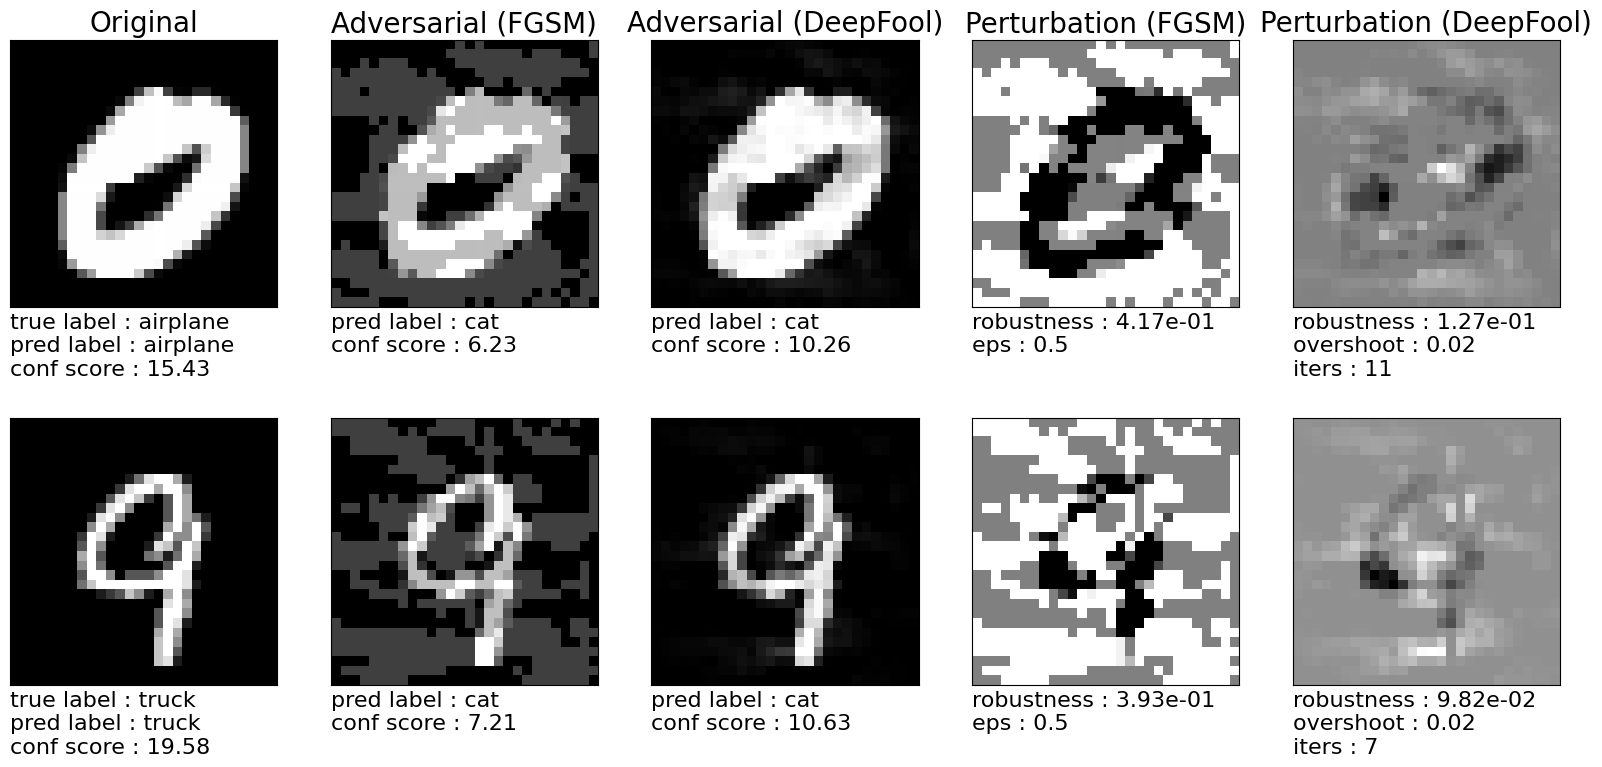

In [ ]:
fgsm_eps = 0.5
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

print('fgsm eps = ', fgsm_eps)
filename = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

**Вывод:** При значении eps равном 0.5 ошибка составляет 83%, но в отличии от других экспериментов искажения сильно заметны

### **Вывод:**
Таким образом при увеличении значений eps увеличиваются искажения на исходных изображениях и снижается точность нейронной сети. Для успешной атаки значение eps не должно быть большим, иначе её слишком легко орбнаружить из-за координальных искажений исходных изображений.

Самая уязвимая для атак нейросеть из рассмотренных – FC на датасете MNIST, так как у этой нейросети больше остальных росла ошибка при атаке.

Кроме того все нейронные сети, рассмотренные в лабораторной работе, уязвимы к атакам при подборе параметров. При точечном подборе точность работы нейронных сетей можно уменьшить на 80% и более.